# Implementing a Graph Neural Network

In this third session we will look at how we can implement a Graph Neural Network. It should be noted that the designspace of GNNs is very large, what we see in this notebook is simply one commonly used architecture. In particular, we choose one which has close simiilarity with _Transformers_.

**This notebook has the solutions for the tasks, find the work notebook without solutions [here](https://drive.google.com/file/d/1-0bMfvrSEOjdjbRumBaoEJMjUwIMZH3e/view?usp=sharing)**

You can find the online version of this notebook [here](https://drive.google.com/file/d/1-oeOcIzqbFSzbultCAhVbhnE41kqCNse/view?usp=sharing)

## Preamble
This section downloads and install a conda environment on your colab virtual machine, which makes dealing with dependencies a lot easier

### Installing condacolab
We will use a package called condacolab which will download an initialize a conda environment which we can later install packages to

In [ ]:
#Preamble, this will install a conda (mamba actually) environment on your Colab VM, which really makes working with complex dependencies (RDKit in this case) easier.
# YOU WILL LIKELY GET A NOTIFICATION ABOUT YOUR SESSION CRASHING, THIS IS EXPECTED BEHAVIOUR (the install will restart the python kernel). 
# Wait until this cell is done before running the rest of the notebook.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:33
🔁 Restarting kernel...


In [ ]:
# Check that we now have a working conda environment. You should get the output "Everything looks OK!"
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


### Installing the notebook packages
Now that condacolab is up and running, we install the packages. To install the correct version of cuda toolkits  for pytorch, we first check which version of cuda is installed on the VM. If the last line is not `cuda_11.1.xxx`, you need to change the mamba install line to match the version you see from `nvcc`

In [ ]:
!nvcc --version  # Check what cuda version is installed, this must match the cudatoolkit=XY.Z we give to the mamba install line

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# Install the required packages. Note that condacolab uses mamba (a conda reimplementation) by default. This will likely take about 10 minutes
!mamba install pytorch cudatoolkit=11.1 rdkit -c pytorch -c conda-forge > /dev/null
print("Done installing packages")

Done installing packages


## Graph Neural Networks
We have previously looked at how we can represent graphs as inputs to neural networks and given a working example using chemistry as an application. Now we're going to dive into the details of graph neural network architectures.
We'll take a step back from the previous notebook, and start with an explicit  representations of the graphs (no packing of multiples features into batches).

The figure below illustrates what the GNN Encoder will do. With some graph as input, where the nodes are represented by feature vectors, perform some series of transformations on the graph and output as many transformed vectors as there were vectors in the input.

**The number of vectors should not be fixed to some number, the GNN encoder needs to be able to handly any number of nodes**




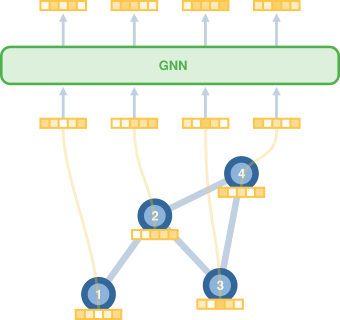

### The fundamental challenge: **How do we go from a variable sized graph input to a fixed size vector?**

To build a neural network which can handle graphs as inputs, it needs to be able to handle inputs of varying size. The layers we commonly use in neural networks eventually performs an matrix-vector product, and the operation needs a fixed size vector, so the fundamental question is how to go from inputs which vary in size (graphs) to some fixed size fector.

We need some kind of thing, let's call it an operator, which takes an arbitrary number of other things (for example node feature vectors in a graph) and outputs a fixed size single thing (a single vector). We typically refer to this as an _aggregation_.

We can think of all sorts of ways of doing this, for example pick the maximum value along each dimensions of all the vectors, pick the minimum, calculate a sum, a mean or a weighted mean.

It turns out that picking mean or max limits the expressivity of our networks, while using a sum gives us neural networks whose power to distinguish between graphs is upper bounded by the Weisfeiler-Lehman test (see this video lecture for an in depth coverage: https://youtu.be/USfNJNePDKQ). For a coverage of the Weisfeiler-Lehman test, see https://youtu.be/buzsHTa4Hgs?t=653).

We will throughout this notebook see how this idea of aggregating an arbitrary collection of vectors using a **sum** allows us to build very flexible neural networks which can use arbitrarily sized sets of vectors as inputs.



## The Graph Data

We'll use the same basic representation as in the previous session, up to the GraphDataset class. Once again we're using molecules as an example, but you can easily replace them with some other graph. One addition we do here is to supply an _adjacency list_ in the returned dictionary from `GraphDataset.__getitem__()`, the reason for this is that we wan't to explicitly show how the aggregation in the GNN works.

### Adjacency list
There are many ways to represent the graph structure (the edge set) of a graph. In the previous notebook we used an _adjacency matrix_, a matrix $A$ of shape $n \times n$, where $n$ is the number of nodes and an element $A_{i,j}$ is $1$ if there is an edge from node $i$ to node $j$ and $0$ otherwise.

We can also represent the same information using other datastructures, and an _adjacency list_ is a common choice. In this case, we use a dictionary as a sparse representation of the adjacency matrix. The keys are the $i$-nodes in the example above, where the value is a list of the $j$'s which are $1$ in the adjacency matrix. For example, the adjacency matrix:

$$\begin{bmatrix}
0& 1& 0& 0& 1\\
1& 0& 0& 0& 1\\
0& 0& 0& 1& 0\\
0& 0& 1& 0& 0\\
1& 1& 0& 0& 0\\
\end{bmatrix}$$

Would be represented by the adjacency ($0$-indexed) list:

```
{ 
  0: [1, 4],
  1: [0, 4],
  2: [3],
  3: [2],
  4: [0,1]
}
```


In [ ]:
from collections import defaultdict
from collections.abc import Set

import rdkit
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
IPythonConsole.drawOptions.addAtomIndices = True  # This will help when looking at the Mol graph representation
IPythonConsole.molSize = 600, 600

import torch
from torch.utils.data import Dataset, DataLoader

float_type = torch.float32  # We're hardcoding types in the tensors further down
categorical_type = torch.long
mask_type = torch.float32  # We're going to be multiplying our internal calculations with a mask using this type
labels_type = torch.float32 # We're going to use BCEWithLogitsLoss, which expects the labels to be of the same type as the predictions

In [ ]:
class ContinuousVariable:
  def __init__(self, name):
    self.name = name

  def __repr__(self):
    return f'<ContinuousVariable: {self.name}>'

  def __eq__(self, other):
    return self.name == other.name

  def __hash__(self):
    return hash(self.name)

class CategoricalVariable:
  def __init__(self, name, values, add_null_value=True):
    self.name = name
    self.has_null_value = add_null_value
    if self.has_null_value:
      self.null_value = None
      values = (None,) + tuple(values)
    self.values = tuple(values)
    self.value_to_idx_mapping = {v: i for i, v in enumerate(values)}
    self.inv_value_to_idx_mapping = {i: v for v, i in self.value_to_idx_mapping.items()}
    
    if self.has_null_value:
      self.null_value_idx = self.value_to_idx_mapping[self.null_value]
  
  def get_null_idx(self):
    if self.has_null_value:
      return self.null_value_idx
    else:
      raise RuntimeError(f"Categorical variable {self.name} has no null value")

  def value_to_idx(self, value):
    return self.value_to_idx_mapping[value]
  
  def idx_to_value(self, idx):
    return self.inv_value_to_idx_mapping[idx]
  
  def __len__(self):
    return len(self.values)
  
  def __repr__(self):
    return f'<CategoricalVariable: {self.name}>'

  def __eq__(self, other):
    return self.name == other.name and self.values == other.values

  def __hash__(self):
    return hash((self.name, self.values))

In [ ]:
ATOM_SYMBOLS = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
                'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 
                'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 
                'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
                'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
                'Ba', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 
                'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Rf', 'Db', 'Sg', 
                'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Fl', 'Lv', 'La', 'Ce', 'Pr', 
                'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 
                'Lu', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 
                'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']
ATOM_SYMBOLS_FEATURE = CategoricalVariable('atom_symbol', ATOM_SYMBOLS)

ATOM_AROMATIC_VALUES = [True, False]
ATOM_AROMATIC_FEATURE = CategoricalVariable('is_aromatic', ATOM_AROMATIC_VALUES)

# In practice you might like to use categroical features for valence, but we use continuous here for demonstration
ATOM_EXPLICIT_VALENCE_FEATURE = ContinuousVariable('explicit_valence')

ATOM_IMPLICIT_VALENCE_FEATURE = ContinuousVariable('implicit_valence')

ATOM_FEATURES = [ATOM_SYMBOLS_FEATURE, ATOM_AROMATIC_FEATURE, ATOM_EXPLICIT_VALENCE_FEATURE, ATOM_IMPLICIT_VALENCE_FEATURE]

def get_atom_features(rd_atom):
  atom_symbol = rd_atom.GetSymbol()
  is_aromatic = rd_atom.GetIsAromatic()
  implicit_valence = float(rd_atom.GetImplicitValence())
  explicit_valence = float(rd_atom.GetExplicitValence())
  return {ATOM_SYMBOLS_FEATURE: atom_symbol,
          ATOM_AROMATIC_FEATURE: is_aromatic,
          ATOM_EXPLICIT_VALENCE_FEATURE: explicit_valence,
          ATOM_IMPLICIT_VALENCE_FEATURE: implicit_valence}

In [ ]:
# We could use the RDKit enumeration types instead of strings, but the advantage
# of doing it like this is that our representation becomes independent of RDKit
BOND_TYPES = ['UNSPECIFIED', 'SINGLE', 'DOUBLE', 'TRIPLE', 'QUADRUPLE', 
              'QUINTUPLE', 'HEXTUPLE', 'ONEANDAHALF', 'TWOANDAHALF',
              'THREEANDAHALF','FOURANDAHALF', 'FIVEANDAHALF', 'AROMATIC', 
              'IONIC', 'HYDROGEN', 'THREECENTER',	'DATIVEONE', 'DATIVE',
              'DATIVEL', 'DATIVER', 'OTHER', 'ZERO']
TYPE_FEATURE = CategoricalVariable('bond_type', BOND_TYPES)

BOND_DIRECTIONS = ['NONE', 'BEGINWEDGE', 'BEGINDASH', 'ENDDOWNRIGHT', 'ENDUPRIGHT', 'EITHERDOUBLE' ]
DIRECTION_FEATURE = CategoricalVariable('bond_direction', BOND_DIRECTIONS)

BOND_STEREO = ['STEREONONE', 'STEREOANY', 'STEREOZ', 'STEREOE', 
               'STEREOCIS', 'STEREOTRANS']
STEREO_FEATURE = CategoricalVariable('bond_stereo', BOND_STEREO)

AROMATIC_VALUES = [True, False]
AROMATIC_FEATURE = CategoricalVariable('is_aromatic', AROMATIC_VALUES)

BOND_FEATURES = [TYPE_FEATURE, DIRECTION_FEATURE, AROMATIC_FEATURE, STEREO_FEATURE]

def get_bond_features(rd_bond):
  bond_type = str(rd_bond.GetBondType())
  bond_stereo_info = str(rd_bond.GetStereo())
  bond_direction = str(rd_bond.GetBondDir())
  is_aromatic = rd_bond.GetIsAromatic()
  return {TYPE_FEATURE: bond_type,
          DIRECTION_FEATURE: bond_direction,
          AROMATIC_FEATURE: is_aromatic,
          STEREO_FEATURE: bond_stereo_info}

In [ ]:
def rdmol_to_graph(mol):
  atoms = {rd_atom.GetIdx(): get_atom_features(rd_atom) for rd_atom in mol.GetAtoms()}
  bonds = {frozenset((rd_bond.GetBeginAtomIdx(), rd_bond.GetEndAtomIdx())): get_bond_features(rd_bond) for rd_bond in mol.GetBonds()}
  return atoms, bonds

In [ ]:
def smiles_to_graph(smiles):
  rd_mol = MolFromSmiles(smiles)
  graph = rdmol_to_graph(rd_mol)
  return graph

In [ ]:
g = smiles_to_graph('c1ccccc1')

In [ ]:
class GraphDataset(Dataset):
  def __init__(self, *, graphs, labels, node_variables, edge_variables, metadata=None):
    '''
    Create a new graph dataset, 
    '''
    self.graphs = graphs
    self.labels = labels
    assert len(self.graphs) == len(self.labels), "The graphs and labels lists must be the same length"
    self.metadata = metadata
    if self.metadata is not None:
      assert len(self.metadata) == len(self.graphs), "The metadata list needs to be as long as the graphs"
    self.node_variables = node_variables
    self.edge_variables = edge_variables
    self.categorical_node_variables = [var for var in self.node_variables if isinstance(var, CategoricalVariable)]
    self.continuous_node_variables = [var for var in self.node_variables if isinstance(var, ContinuousVariable)]
    self.categorical_edge_variables = [var for var in self.edge_variables if isinstance(var, CategoricalVariable)]
    self.continuous_edge_variables = [var for var in self.edge_variables if isinstance(var, ContinuousVariable)]

  def __len__(self):
    return len(self.graphs)

  def make_continuous_node_features(self, nodes):
    if len(self.continuous_node_variables) == 0:
      return None
    n_nodes = len(nodes)
    n_features = len(self.continuous_node_variables)
    continuous_node_features = torch.zeros((n_nodes, n_features), dtype=float_type)
    for node_idx, features in nodes.items():
      node_features = torch.tensor([features[continuous_feature] for continuous_feature in self.continuous_node_variables], dtype=float_type)
      continuous_node_features[node_idx] = node_features
    return continuous_node_features
      
  def make_categorical_node_features(self, nodes):
    if len(self.categorical_node_variables) == 0:
      return None
    n_nodes = len(nodes)
    n_features = len(self.categorical_node_variables)
    categorical_node_features = torch.zeros((n_nodes, n_features), dtype=categorical_type)

    for node_idx, features in nodes.items():
      for i, categorical_variable in enumerate(self.categorical_node_variables):
          value = features[categorical_variable]
          value_index = categorical_variable.value_to_idx(value)
          categorical_node_features[node_idx, i] = value_index

    return categorical_node_features

  def make_continuous_edge_features(self, n_nodes, edges):
    if len(self.continuous_edge_variables) == 0:
      return None
    n_features = len(self.continuous_edge_variables)
    continuous_edge_features = torch.zeros((n_nodes, n_nodes, n_features), dtype=float_type)
    for edge, features in edges.items():
      edge_features = torch.tensor([features[continuous_feature] for continuous_feature in self.continuous_edge_variables], dtype=float_type)
      u,v = edge
      continuous_edge_features[u, v] = edge_features
      if isinstance(edge, Set):
        continuous_edge_features[v, u] = edge_features

    return continuous_edge_features

  def make_categorical_edge_features(self, n_nodes, edges):
    if len(self.categorical_edge_variables) == 0:
      return None
    n_features = len(self.categorical_edge_variables)
    categorical_edge_features = torch.zeros((n_nodes, n_nodes, n_features), dtype=categorical_type)

    for edge, features in edges.items():
      u,v = edge
      for i, categorical_variable in enumerate(self.categorical_edge_variables):
          value = features[categorical_variable]
          value_index = categorical_variable.value_to_idx(value)
          categorical_edge_features[u, v, i] = value_index
          if isinstance(edge, Set):
            categorical_edge_features[v, u, i] = value_index

    return categorical_edge_features
  
  def __getitem__(self, index):
    # This is where the important stuff happens. We use our node and 
    # edge variable attributes to select what node and edge features to use.
    # In practice, we often do this as a pre-processing step, but here we do it 
    # in the getitem function for clarity

    graph = self.graphs[index]
    nodes, edges = graph
    n_nodes = len(nodes)
    continuous_node_features = self.make_continuous_node_features(nodes)
    categorical_node_features = self.make_categorical_node_features(nodes)
    continuous_edge_features = self.make_continuous_edge_features(n_nodes, edges)
    categorical_edge_features = self.make_categorical_edge_features(n_nodes, edges)

    label = self.labels[index]

    nodes_idx = sorted(nodes.keys())
    edge_list = sorted(edges.keys())

    n_nodes = len(nodes)
    adjacency_matrix = torch.zeros((n_nodes, n_nodes), dtype=float_type)
    for edge in edges:
      u, v = edge
      adjacency_matrix[u,v] = 1
      if isinstance(edge, Set):
        # This edge is unordered, assume this is a undirected graph
        adjacency_matrix[v,u] = 1

    adjacency_list = defaultdict(list)
    for edge in edges:
      u,v = edge
      adjacency_list[u].append(v)
      # Assume undirected graph is the edge is a set
      if isinstance(edge, Set):
        adjacency_list[v].append(u)

    data_record = {'nodes': nodes_idx,
                   'adjacency_matrix': adjacency_matrix,
                   'adjacency_list': adjacency_list,
                   'categorical_node_features': categorical_node_features,
                   'continuous_node_features': continuous_node_features,
                   'categorical_edge_features': categorical_edge_features,
                   'continuous_edge_features': continuous_edge_features,
                   'label': label}

    # If you need to add extra information (metadata about this graph) you can 
    # add an extra key-value pair here. The advantage of using a dict compared 
    # to a tuple is that the downstreams code doesn't break as long as at least 
    # the expected keys are present. The downside is that using a dict adds 
    # overhead (accessing a dict compared to unpacking a tuple).
    # A more robust implementation might actually make a separate class for 
    # dataset entires
    if self.metadata is not None:
      data_record['metadata'] = self.metadata[index]
    return data_record

  def get_node_variables(self):
    return {'continuous': self.continuous_node_variables,
            'categorical': self.categorical_node_variables}
  
  def get_edge_variables(self):
    return {'continuous': self.continuous_edge_variables,
            'categorical': self.categorical_edge_variables}

In [ ]:
def make_molecular_graph_dataset(smiles_records, atom_features=ATOM_FEATURES, bond_features=BOND_FEATURES):
  '''
  Create a new GraphDataset from a list of smiles_records dictionaries.
  These records should contain the key 'smiles' and 'label'. Any other keys will be saved as a 'metadata' record.
  '''
  graphs = []
  labels = []
  metadata = []
  for smiles_record in smiles_records:
    smiles = smiles_record['smiles']
    label = smiles_record['label']
    graph = smiles_to_graph(smiles)
    graphs.append(graph)
    labels.append(label)
    metadata.append(smiles_record)
  return GraphDataset(graphs=graphs, 
                      labels=labels, 
                      node_variables=atom_features, 
                      edge_variables=bond_features, 
                      metadata=metadata)
  

In [ ]:
dataset = make_molecular_graph_dataset([{'smiles': 'c1ccccc1', 'label':1},{'smiles':'OS(=O)(=O)O', 'label': 0}])
dataset[1]

{'adjacency_list': defaultdict(list,
             {0: [1], 1: [0, 2, 3, 4], 2: [1], 3: [1], 4: [1]}),
 'adjacency_matrix': tensor([[0., 1., 0., 0., 0.],
         [1., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.]]),
 'categorical_edge_features': tensor([[[0, 0, 0, 0],
          [2, 1, 2, 1],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]],
 
         [[2, 1, 2, 1],
          [0, 0, 0, 0],
          [3, 1, 2, 1],
          [3, 1, 2, 1],
          [2, 1, 2, 1]],
 
         [[0, 0, 0, 0],
          [3, 1, 2, 1],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]],
 
         [[0, 0, 0, 0],
          [3, 1, 2, 1],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]],
 
         [[0, 0, 0, 0],
          [2, 1, 2, 1],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]]),
 'categorical_node_features': tensor([[ 8,  2],
         [16,  2],
         [

## GNN bottom up
We'll now go through building a basic GNN step by step. The main character of this story will be the `GraphLayer` and how we can implement that. We'll start with a very explicit way of doing it using the adjacency list, and build our way to a more compact way using the adjacency matrix. Before the embedding layers though, we need to combine our node and edge features into single vectors like we looked at in the `01` notebooks.

### No batches
To make things easier to follow, we will be working with single graphs in these first neural network layers. We'll work ourselved towards using mini-batches through this notebook.

### Simple example graph
In this case we'll use the very simple example graph, mostly because it's very small




In [ ]:
import torch
from torch.nn import Embedding, Module, ModuleList

In [ ]:
# These are the settings we'll use when going through building the GNN
# in practice its a good idea to package them in a class (e.g a dataclass)
d_model = 8  # The dimensionality of all vectors in the model.
ffn_dim = 12  # We'll use two layer neural nets and different places in the GNN, here we often make the hidden layer larger than d_model


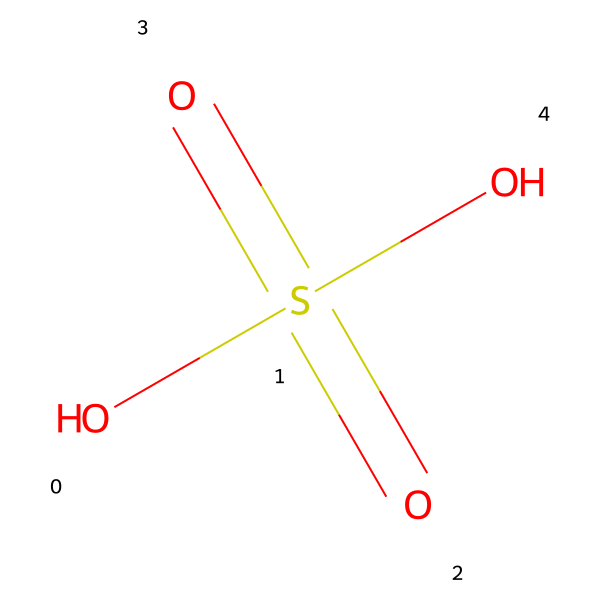

In [ ]:
# Example graph
example_graph = dataset[1]
MolFromSmiles(example_graph['metadata']['smiles'])

### The embeddings
As we've seen previously, we need an `Embedding` layer to deal with our categorical variables. Since we have more than one categorical variable, we need to instantiate a separate embedding for each of them. 

In this example, we will sum the different embedding vectors to create our full node and edge features. You could also concatenate the embeddings, but then you have to make sure the dimensionality is correct by applying a linear projection, after which you're essentially summing the embeddings anyways (albeit with slightly different parameterizations).




In [ ]:
# Let's have a look at how the categorical node features are represented
dataset[1]['categorical_node_features']

tensor([[ 8,  2],
        [16,  2],
        [ 8,  2],
        [ 8,  2],
        [ 8,  2]])

As you can see, the categorical node features are represented by a matrix of shape (n_nodes, n_features). Since each column correspond to a different categorical variable we need to treat them separately.



### Embedding dimensionality
Since we're summing the embeddings, we can choose an embedding dimensionality which is `d_model`, however we also have _continuous variables_ to consider. In this example, the vector of continuous values will be concatenated to the summed embeddings, so we make the embedding dimensionality the difference between `d_model` and the number of continuous embeddings.

In [ ]:
class Embedder(Module):
  def __init__(self, categorical_variables, embedding_dim):
    super().__init__()
    self.categorical_variables = categorical_variables
    embeddings = []
    for var in categorical_variables:
      num_embeddings = len(var)
      if var.has_null_value:
        # It's not uncommon to have missing values, we support this assinging a special 0-index which have the zero-vector as its embedding
        embedding = Embedding(num_embeddings, embedding_dim, padding_idx=var.get_null_idx())
      else:
        embedding = Embedding(num_embeddings, embedding_dim)
      embeddings.append(embedding)
    self.embeddings = ModuleList(embeddings)
    
  
  def forward(self, categorical_features):
    # The node features is a matrix with as many rows as nodes of our graph
    # and as many columns as we have categorical features
    all_embedded_vars = []
    for i, embedding in enumerate(self.embeddings):
      # We pick out just the i'th column. The ellipsis '...' in a numpy-style 
      # slice is a useful way of saying you want full range over all other axises
      # We use it so that this can actually take a categorical_features array
      # with arbitrary number of trailing axises to support both the node 
      # features, the edge features and the mini-batched version of both
      var_indices = categorical_features[..., i]  
      embedded_vars = embedding(var_indices)
      all_embedded_vars.append(embedded_vars)

    # If you like, you can implement concatenation instead of sum here
    stacked_embedded_vars = torch.stack(all_embedded_vars, dim=0)
    embedded_vars = torch.sum(stacked_embedded_vars, dim=0)
    return embedded_vars

````{exercise} Question 1
 do you follow what's going on in the forward of the Embedder?
````

Let's try this out. Our `GraphDataset` keeps track of which node features it has, we'll use that to instantiate our `NodeEmbedder`

In [ ]:
categorical_node_features = dataset[1]['categorical_node_features']
categorical_node_features

tensor([[ 8,  2],
        [16,  2],
        [ 8,  2],
        [ 8,  2],
        [ 8,  2]])

In [ ]:
num_categorical_node_variables = len(dataset.categorical_node_variables)
num_continuous_node_variables = len(dataset.continuous_node_variables)
node_embedding_dim = d_model - num_continuous_node_variables

In [ ]:
node_embedder = Embedder(dataset.categorical_node_variables, node_embedding_dim)
node_embedder(categorical_node_features)

tensor([[ 0.0182,  1.9039,  0.8687, -0.5604,  0.1463, -0.1737],
        [ 2.8172,  0.5841, -1.6437,  2.2051, -0.0943, -0.5309],
        [ 0.0182,  1.9039,  0.8687, -0.5604,  0.1463, -0.1737],
        [ 0.0182,  1.9039,  0.8687, -0.5604,  0.1463, -0.1737],
        [ 0.0182,  1.9039,  0.8687, -0.5604,  0.1463, -0.1737]],
       grad_fn=<SumBackward1>)

As you can see, our node feature embedder returns as many vectors as we had nodes in our dataset. The length of the vectors are `embedding_dim`, which is the same as `d_model - len(continuous_node_features)`

### Combining the embedded features with the continuous
Once we have the embedded features, we want to combine them with the continuous features. In difference from combining the embeddings with a sum, we'll concatenate the continuous features to the summed embeddings.

In difference from how summing embeddings make sense, summing the continuous features to the embeddings are not the same. This is due to two things: 
  1. each continuous feature is scalar and will always just be able to span a single line in feature space. The network can't easily learn to separate one value of the continuous feature from another, and 
  2. the reason for why summing embeddings togheter is as expressive as concatenation is because the embeddings are all _free variables_, while our continuous features are not.

  We'll now create a `Module` which will take care of our node featurization. It will take one matrix containing the categorical features and one containing the continuous and embed the categoricals followed by concatenating the continuous.


In [ ]:
class FeatureCombiner(Module):
  def __init__(self, categorical_variables, embedding_dim):
    super().__init__()
    self.categorical_variables = categorical_variables
    self.embedder = Embedder(self.categorical_variables, embedding_dim)
    
  def forward(self, continuous_features, categorical_features, ):
    # We need to be agnostic to whether we have categorical features and continuous features (it's not uncommon to only use one kind)
    features = []
    if categorical_features is not None:
      embedded_features = self.embedder(categorical_features)
      features.append(embedded_features)
      # The embedded features are now of shape (n_nodes, embedding_dim)
    if continuous_features is not None:
      features.append(continuous_features)
    if len(features) == 0:
      raise RuntimeError('No features to combine')
    full_features = torch.cat(features, dim=-1)  # Now we concatenate along the feature dimension
    return full_features


````{exercise} Question 2
 can you follow the steps in the FeatureCombiner above?
````

In [ ]:
node_featurizer = FeatureCombiner(dataset.categorical_node_variables, node_embedding_dim)
graph = dataset[1]
categorical_node_features = graph['categorical_node_features']
continuous_node_features = graph['continuous_node_features']
print("Categorical node features", categorical_node_features)
print("Continuous node features", continuous_node_features)
print("NodeFeaturizer without continuous features", node_featurizer(None, categorical_node_features))
print("NodeFeaturizer without categorical features", node_featurizer(continuous_node_features, None))
print("Combined features", node_featurizer(continuous_node_features, categorical_node_features))
print("Shape of combined features", node_featurizer(continuous_node_features, categorical_node_features).shape)

Categorical node features tensor([[ 8,  2],
        [16,  2],
        [ 8,  2],
        [ 8,  2],
        [ 8,  2]])
Continuous node features tensor([[1., 1.],
        [6., 0.],
        [2., 0.],
        [2., 0.],
        [1., 1.]])
NodeFeaturizer without continuous features tensor([[ 0.7402, -2.7261,  0.4958, -1.7754, -0.8931,  0.1746],
        [ 2.2503, -2.9387,  1.3418, -1.4895, -0.2801, -3.0297],
        [ 0.7402, -2.7261,  0.4958, -1.7754, -0.8931,  0.1746],
        [ 0.7402, -2.7261,  0.4958, -1.7754, -0.8931,  0.1746],
        [ 0.7402, -2.7261,  0.4958, -1.7754, -0.8931,  0.1746]],
       grad_fn=<CatBackward0>)
NodeFeaturizer without categorical features tensor([[1., 1.],
        [6., 0.],
        [2., 0.],
        [2., 0.],
        [1., 1.]])
Combined features tensor([[ 0.7402, -2.7261,  0.4958, -1.7754, -0.8931,  0.1746,  1.0000,  1.0000],
        [ 2.2503, -2.9387,  1.3418, -1.4895, -0.2801, -3.0297,  6.0000,  0.0000],
        [ 0.7402, -2.7261,  0.4958, -1.7754, -0.8931,  

### Edge features
While we won't be using the edge features right away, the classes we've defined can handle them as well. Remember, we choose to represent the edge features as dense arrays of shape `(n_nodes, n_nodes, num_features)`. This is not a problem since the classes we have defined are agnostic to all axises besides the last.

In [ ]:
categorical_edge_features = dataset[1]['categorical_edge_features']
categorical_edge_features

tensor([[[0, 0, 0, 0],
         [2, 1, 2, 1],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[2, 1, 2, 1],
         [0, 0, 0, 0],
         [3, 1, 2, 1],
         [3, 1, 2, 1],
         [2, 1, 2, 1]],

        [[0, 0, 0, 0],
         [3, 1, 2, 1],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 0],
         [3, 1, 2, 1],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 0],
         [2, 1, 2, 1],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]])

In [ ]:
num_categorical_edge_variables = len(dataset.categorical_edge_variables)
num_continuous_edge_variables = len(dataset.continuous_edge_variables)
edge_embedding_dim = d_model - num_continuous_edge_variables

In [ ]:
edge_embedder = Embedder(dataset.categorical_edge_variables, edge_embedding_dim)
edge_embedder(categorical_edge_features)

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [-0.2533,  3.5066, -0.8622, -0.6412,  0.7749, -1.3195,  3.2126,
          -1.3701],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000]],

        [[-0.2533,  3.5066, -0.8622, -0.6412,  0.7749, -1.3195,  3.2126,
          -1.3701],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.2966,  3.7243, -2.4868, -2.2401, -0.7641, -1.3056,  2.1690,
          -1.4981],
         [ 0.2966,  3.7243, -2.4868, -2.2401, -0.7641, -1.3056,  2.1690,
          -1.4981],
         [-0.2533,  3.5066, -0.8622, -0.6412,  0.7749, -1.3195,  3.2126,
          -1.3701]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0

As you can see, there are many 0s in these features. This is because this matrix of edge features have missing values where there are no edges.

In [ ]:
edge_featurizer = FeatureCombiner(dataset.categorical_edge_variables, edge_embedding_dim)
graph = dataset[1]
categorical_edge_features = graph['categorical_edge_features']
continuous_edge_features = graph['continuous_edge_features']
print("Categorical edge features", categorical_edge_features)
print("Continuous edge features", continuous_edge_features)
print("FeatureCombiner without continuous features", edge_featurizer(None, categorical_edge_features))
# Our edges have only categorical features, so we skip the example without them
# print("FeatureCombiner without categorical features", edge_featurizer(continuous_edge_features, None))
print("Combined features", edge_featurizer(continuous_edge_features, categorical_edge_features))
print("Shape of combined features", edge_featurizer(continuous_edge_features, categorical_edge_features).shape)

Categorical edge features tensor([[[0, 0, 0, 0],
         [2, 1, 2, 1],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[2, 1, 2, 1],
         [0, 0, 0, 0],
         [3, 1, 2, 1],
         [3, 1, 2, 1],
         [2, 1, 2, 1]],

        [[0, 0, 0, 0],
         [3, 1, 2, 1],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 0],
         [3, 1, 2, 1],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 0],
         [2, 1, 2, 1],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]])
Continuous edge features None
FeatureCombiner without continuous features tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [-1.1434, -0.9344, -0.0361, -0.4400, -3.6863,  3.9750,  0.7559,
          -0.6479],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.0000,  0.0000,  0.0000,

## The Graph Layer
We now have the input we want to feed into our graph layers. We have a `(n_nodes, num_node_features)` matrix for our node features and a `(num_nodes, num_nodes, num_edge_features)` for our edges.

In addition to this, we need to tell our graph layer what the structure of the graph is by supplying the adjacency matrix. 




### Graph "convolutions"

The underlying idea behind a graph neural network is to use the **structure** of the graph to **route information**. Each successive graph layer collects and transform information from the previous. In difference from a Multi Layer Perceptron-like neural network, the inputs to a graph neural network have different shape since each graph is likely to have different number of nodes. We've already looked at how we create feature vectors for each of our nodes, and this is what we use as inputs to our neural network.

The way we make our network invariant to the size of the graph is constructing it around similar concepts as Convolutional Neural Networks. We define a kernel, a function which is "translation" invariant, and we apply this function to all interesting parts of the input. In the case of a CNN, we often think of these are being grid cells in the pixel grid, and in GNNs we'll use the nodes of the graphs as the "centers" for our "convolutions".


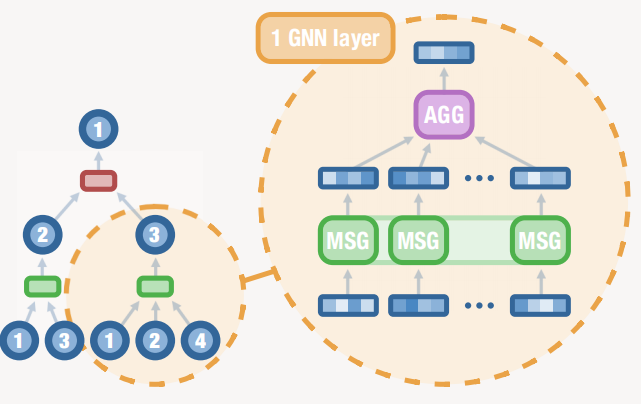

### the Aggregation function
Apart from the center node, which will always be one, we want to take the structure into account. In a GNN this is done by making the "kernel" take information from all adjacent nodes as additional inputs. 

We are then again faced with the same problem as before, this function needs to be able to take arbitrary amounts of vectors as inputs (the neighbourhoods are typically of different size).

Once again we take inspiration from CNNs. In convolutions, the way neighbouring pixel values are taken into account is through a **sum**, and that's exactly what we will use to define a kernel function which can operate on arbitrary sized neighbourhoods.

So the aggregation we will use is simply the sum of all vectors in a neighbourhood:

$$\sum_{j \in N(i)} \mathbf{x}_j$$

Where $N(i)$ return the indices of all nodes which are neighbours of $i$. The vectors $\mathbf{x}_j$ are will be the node vectors of the neighbours _after_ they have been transformed by our message function.

### The message function
Just summing the vectors will not allow our model to learn anything more interesting than continuous bag of words. To learn more interesting function of the graphs, we need some nonlinearities. Throughout this notebook, we'll often use a simple 2-layer MLP neural network for this. It will take node or edge feature vectors as input and return transformations of them as outputs.

For now we'll use a common setup where we apply transformations to the nodes vectors before aggregation. Think of this as composing a message from the nodes current information (its state vector).

We might also want to apply a nonlinear transformation after aggregation, to essentially filter out what information is important from the messages we recieved.

When we aggregate the information from the neighbourhood, we also add in what the previous information of the "centered" node, and we might wan't to do some processing on that before (applying a nonlinear transformation through an MLP)

````{exercise} Task 1
 Implement the aggregation using a `for` loop over the `adjacency_list` in the `forward` below
````

For example, the adjacency matrix:

$$\begin{bmatrix}
0& 1& 0& 0& 1\\
1& 0& 0& 0& 1\\
0& 0& 0& 1& 0\\
0& 0& 1& 0& 0\\
1& 1& 0& 0& 0\\
\end{bmatrix}$$

Would be represented by the adjacency ($0$-indexed) list:

```
{ 
  0: [1, 4],
  1: [0, 4],
  2: [3],
  3: [2],
  4: [0,1]
}
```

You only need to implement the step which picks out the neighbour node feature vectors for each "center" node

In [ ]:
from torch.nn import Sequential, Linear, ReLU

In [ ]:
class AdjacencyListGraphLayer(Module):
  def __init__(self, input_dim, output_dim, ffn_dim):
    super().__init__()
    self.neighbour_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.center_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.output_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
  
  def forward(self, adjacency_list, node_features):
    # First we create separate representations of nodes when they are neighbours 
    # and nodes when they are the center node. The new tensor will have the same 
    # shape as before
    neighbour_updated_node_features = self.neighbour_mlp(node_features)
    center_updated_node_features = self.center_mlp(node_features)
    
    # Now for the aggregation. In this case we'll make it very explicit by
    # using our adjacency list. Rembember that this is a dictionary with 
    # node indices as keys and lists of neighbour indices as values
    aggregated_neighbourhoods = []
    for node_idx, neighbours in adjacency_list.items():
      ## Create a list of neighbour feature vectrors
      neighbourhood = ...  #TASK: Your code should assign the list of neighbour vectors to this variable
      neighbourhood = torch.stack(neighbourhood, dim=0) 
      center_node = center_updated_node_features[node_idx]
      aggregated_neighbourhood = torch.sum(neighbourhood, dim=0) + center_node
      aggregated_neighbourhoods.append(aggregated_neighbourhood)
    
    # Here we have to be mindful of the order of axises. Right now we're assuming
    # the inputs are single graphs. If it was a batch we might need to change
    # what dimension we stack the neighbourhood on to keep the same order as the
    # input
    aggregated_neighbourhoods = torch.stack(aggregated_neighbourhoods, dim=0)
    updated_node_features = self.output_mlp(aggregated_neighbourhoods)
    return updated_node_features
    

````{solution}

```python
class AdjacencyListGraphLayer(Module):
  def __init__(self, input_dim, output_dim, ffn_dim):
    super().__init__()
    self.neighbour_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.center_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.output_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
  
  def forward(self, adjacency_list, node_features):
    # First we create separate representations of nodes when they are neighbours 
    # and nodes when they are the center node. The new tensor will have the same 
    # shape as before
    neighbour_updated_node_features = self.neighbour_mlp(node_features)
    center_updated_node_features = self.center_mlp(node_features)
    
    # Now for the aggregation. In this case we'll make it very explicit by
    # using our adjacency list. Rembember that this is a dictionary with 
    # node indices as keys and lists of neighbour indices as values
    aggregated_neighbourhoods = []
    for node_idx, neighbours in adjacency_list.items():
      ## Create a list of neighbour feature vectrors
      neighbourhood = [neighbour_updated_node_features[neighbour_idx] for neighbour_idx in neighbours]
      neighbourhood = torch.stack(neighbourhood, dim=0) 
      center_node = center_updated_node_features[node_idx]
      aggregated_neighbourhood = torch.sum(neighbourhood, dim=0) + center_node
      aggregated_neighbourhoods.append(aggregated_neighbourhood)
    
    # Here we have to be mindful of the order of axises. Right now we're assuming
    # the inputs are single graphs. If it was a batch we might need to change
    # what dimension we stack the neighbourhood on to keep the same order as the
    # input
    aggregated_neighbourhoods = torch.stack(aggregated_neighbourhoods, dim=0)
    updated_node_features = self.output_mlp(aggregated_neighbourhoods)
    return updated_node_features
```
````

In [ ]:
*torch.manual_seed(1729)  # We set the seed so layers are initialized the same for illustrative purposes
adjacency_list_graph_layer = AdjacencyListGraphLayer(d_model, d_model, ffn_dim)

In [ ]:
node_featurizer = FeatureCombiner(dataset.categorical_node_variables, node_embedding_dim)
graph = dataset[1]
adjacency_list = graph['adjacency_list']
categorical_node_features = graph['categorical_node_features']
continuous_node_features = graph['continuous_node_features']
node_features = node_featurizer(continuous_node_features, categorical_node_features)
node_features

tensor([[ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  1.0000,  1.0000],
        [-1.1473, -2.2324, -1.7766,  1.0580, -2.5067,  2.5195,  6.0000,  0.0000],
        [ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  2.0000,  0.0000],
        [ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  2.0000,  0.0000],
        [ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  1.0000,  1.0000]],
       grad_fn=<CatBackward0>)

In [ ]:
adjacency_list_graph_layer(adjacency_list, node_features)

tensor([[-0.1066, -0.4028,  0.2423,  0.3113,  0.2667, -0.0808,  0.1618,  0.0887],
        [-0.0926, -0.5038,  0.2071,  0.2262,  0.5405, -0.2461,  0.1659,  0.0698],
        [-0.1283, -0.3574,  0.2393,  0.3194,  0.2659, -0.0828,  0.1610,  0.1128],
        [-0.1283, -0.3574,  0.2393,  0.3194,  0.2659, -0.0828,  0.1610,  0.1128],
        [-0.1066, -0.4028,  0.2423,  0.3113,  0.2667, -0.0808,  0.1618,  0.0887]],
       grad_fn=<AddmmBackward0>)

### Using the adjacency matrix instead of the adjacency list
In the above example, we explicitly iterated over the adjacency list to aggregate the neighbourhood.

If we think about this, this is kind of like performing a weighted sum of _all_ the other nodes, where the weight is $1$ if the other node is a neighbour, and $0$ if its not.

$$ \sum_{j \in N(i)} x_j = \sum_j^n \mathbf{1}_{(i,j) \in E} x_j$$

Here $\mathbf{1}_{(i,j) \in E}$ is the indicator function which takes the value $1$ if the edge $(i,j)$ is in the edge set $E$ (the nodes are neighbours) and $0$ otherwise.

For a single center node $i$ this can also be written as a vector-matrix multiplication:

$$\begin{bmatrix} \mathbf{1}_{(i,1) \in E}& \mathbf{1}_{(i,2) \in E}& ... & \mathbf{1}_{(i,n) \in E} \end{bmatrix}
\begin{bmatrix} x_1\\ x_2\\ \vdots \\ x_n \end{bmatrix} $$

And to apply this "convolution" to all nodes we can use a matrix multiplication
$$\begin{bmatrix} 
\mathbf{1}_{(1,1) \in E}& ... & \mathbf{1}_{(1,n) \in E} \\
\vdots & \ddots &  \vdots \\
\mathbf{1}_{(n,1) \in E}& ... & \mathbf{1}_{(n,n) \in E} \\
\end{bmatrix}
\begin{bmatrix} x_1\\ x_2\\ \vdots \\ x_n \end{bmatrix} $$


While this looks complicated, this matrix of indicator functions is actually the **adjacency matrix**. This means that the whole neighbourhood aggregation can be performed with a single matrix multiplication
$$A \begin{bmatrix} x_1\\ x_2\\ \vdots \\ x_n \end{bmatrix} $$

To illustrate the aggregation in more detail, look at the figure below. Each subfigure shows you the aggregation step of one neighbourhood (one row from the adjacency matrix) and how this essentially _masks_ out part of the node features. The matrix multiplication ends by summing all these values into a new vector.

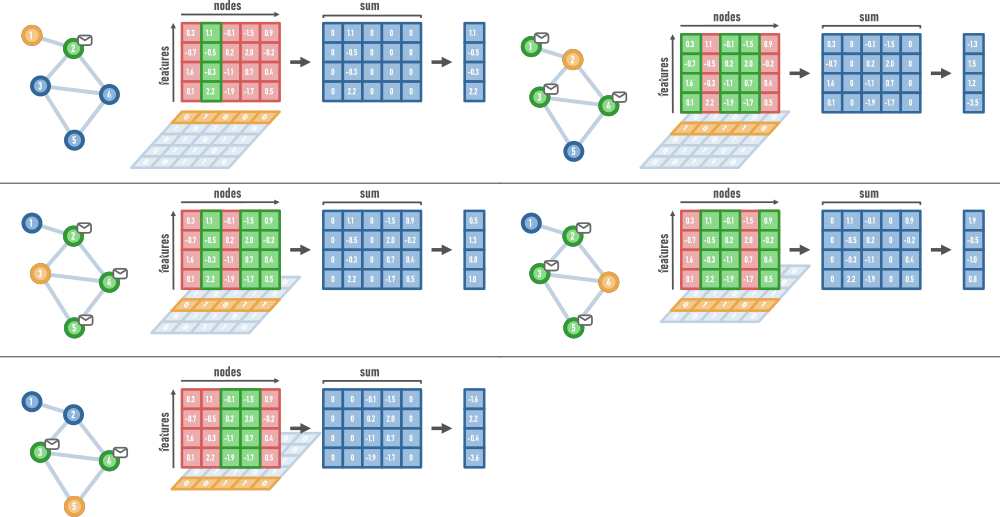

### Isn't this a terribly innefficient way of aggregating?
Yes, it often is. This depends on how sparse the graph is, but if our adjacency matrix is mostly zeroes this will be terribly innefient unless that multiplication actually uses sparse representations and computations.

**There's a reason we show this way of doing it: we're paving the way for Transformers in the next notebook.**


````{exercise} Task 2
 Implement the neighbourhood aggregation using the adjacency matrix
````

In [ ]:
class AdjacencyMatrixGraphLayer(Module):
  def __init__(self, input_dim, output_dim, ffn_dim):
    super().__init__()
    self.neighbour_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.center_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.output_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
  
  def forward(self, adjacency_matrix, node_features):
    # First we create separate representations of nodes when they are neighbours 
    # and nodes when they are the center node. The new tensor will have the same 
    # shape as before
    neighbour_updated_node_features = self.neighbour_mlp(node_features)
    center_updated_node_features = self.center_mlp(node_features)
    
    # Now for the aggregation. Use the adjacencty matrix as illustrated above.
    # Use torch.matmul, and note that it will perform _batched_ matrix 
    # multiplication if the arguments are not matrices
    aggregated_neighbourhood = ... # TASK: You code should perform the aggregation using matrix multiplication here
    aggregated_neighbourhood = aggregated_neighbourhood + center_updated_node_features

    updated_node_features = self.output_mlp(aggregated_neighbourhood)
    return updated_node_features
    

````{solution}

```python
class AdjacencyMatrixGraphLayer(Module):
  def __init__(self, input_dim, output_dim, ffn_dim):
    super().__init__()
    self.neighbour_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.center_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.output_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
  
  def forward(self, adjacency_matrix, node_features):
    # First we create separate representations of nodes when they are neighbours 
    # and nodes when they are the center node. The new tensor will have the same 
    # shape as before
    neighbour_updated_node_features = self.neighbour_mlp(node_features)
    center_updated_node_features = self.center_mlp(node_features)
    
    # Now for the aggregation. Use the adjacencty matrix as illustrated above.
    # Use torch.matmul, and note that it will perform _batched_ matrix 
    # multiplication if the arguments are not matrices
    aggregated_neighbourhood = torch.matmul(adjacency_matrix, 
                                            neighbour_updated_node_features)
    aggregated_neighbourhood = aggregated_neighbourhood + center_updated_node_features

    updated_node_features = self.output_mlp(aggregated_neighbourhood)
    return updated_node_features
```
````

In [ ]:
torch.manual_seed(1729)  # We set the seed so layers are initialized the same for illustrative purposes
adjacency_matrix_graph_layer = AdjacencyMatrixGraphLayer(d_model, d_model, ffn_dim)

In [ ]:
node_featurizer = FeatureCombiner(dataset.categorical_node_variables, node_embedding_dim)
graph = dataset[1]
adjacency_matrix = graph['adjacency_matrix']
categorical_node_features = graph['categorical_node_features']
continuous_node_features = graph['continuous_node_features']
node_features = node_featurizer(continuous_node_features, categorical_node_features)
node_features

tensor([[ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  1.0000,  1.0000],
        [-1.1473, -2.2324, -1.7766,  1.0580, -2.5067,  2.5195,  6.0000,  0.0000],
        [ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  2.0000,  0.0000],
        [ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  2.0000,  0.0000],
        [ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  1.0000,  1.0000]],
       grad_fn=<CatBackward0>)

````{exercise} Task 3
 Compare the outputs of your methods of aggregation
````

They should give the same (or almost the same since we're doing floating point operations) results

In [ ]:
list_results= adjacency_list_graph_layer(adjacency_list, node_features)

In [ ]:
matrix_results = adjacency_matrix_graph_layer(adjacency_matrix, node_features)

In [ ]:
print("Difference between the adjacency list and the adjacency matrix:",  list_results - matrix_results)

Difference between the adjacency list and the adjacency matrix: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)


## Edge features
We've looked at how we can implement one of the simplest graph layers. Now the question is how to take edge information into account.

The way we do this is by defining a new function which computes different neighbour feature vectors depending on the edge between the center node and the neighbours.

$$
h_i^{l+1} = f_c(h_i^l) + \sum_{j \in N(i)} f_n(h_j^l, e_{i,j})
$$

Here, $f_c$ is the transformation function for the center node values, while
$f_n$ is the transformation function for the neigbhours with the edge as an additional input.



In [ ]:
class AdjacencyListEdgeFeaturesGraphLayer(Module):
  def __init__(self, input_dim, output_dim, ffn_dim):
    super().__init__()
    self.neighbour_edges_mlp = Sequential(Linear(2*input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.center_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.output_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
  
  def forward(self, adjacency_list, node_features, edge_features):
    # Since the transformed values of neighbours is now dependent on the edge
    # features, we can't just transform them as in the previous example, we
    # have to do that in the aggregation loop instead
    center_updated_node_features = self.center_mlp(node_features)
    
    # We're using the adjacency list again. instead of just selecting the 
    # neighbour, we'll also compute their updated value dependent on the edge
    # feature between the center node and the neighbour
    aggregated_neighbourhoods = []
    for node_idx, neighbours in adjacency_list.items():
      neighbourhood = []
      for neighbour_idx in neighbours:
        # We chose to represent the edge featuers by a 3-tensor of shape 
        # (n_nodes, n_nodes, num_edge_features). This means that we pick out the
        # feature vector by indexing the the first two axises using the center 
        # node and neighbour node indices
        edge = edge_features[node_idx, neighbour_idx]
        neighbour = node_features[neighbour_idx]
        # Once again we sum vectors to combine them. You could also 
        # concatenate here if it's you want the inductive bias that the 
        # order matters (i.e. f(x, y) != f(y, x))
        neighbour_edge_vector = torch.cat([edge, neighbour], dim=-1)
        neighbour_updated_node_features = self.neighbour_edges_mlp(neighbour_edge_vector)
        neighbourhood.append(neighbour_updated_node_features)

      neighbourhood = torch.stack(neighbourhood, dim=0) 
      center_node = center_updated_node_features[node_idx]
      aggregated_neighbourhood = torch.sum(neighbourhood, dim=0) + center_node
      aggregated_neighbourhoods.append(aggregated_neighbourhood)
    
    # Here we have to be mindful of the order of axises. Right now we're assuming
    # the inputs are single graphs. If it was a batch we might need to change
    # what dimension we stack the neighbourhood on to keep the same order as the
    # input
    aggregated_neighbourhoods = torch.stack(aggregated_neighbourhoods, dim=0)
    updated_node_features = self.output_mlp(aggregated_neighbourhoods)
    return updated_node_features
    

````{exercise} Question 3
 What would you need to change to use concatenated edge and neighbour vectors instead of summed?
````

````{solution}

`self.neighbour_edges_mlp = Sequential(Linear(input_dim*2, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
` and
`neighbour_edge_vector = torch.cat([edge, neighbour], dim=-1)`
Assuming the edge and neighbour vectors are of dimension `input_dim`
````

In [ ]:
torch.manual_seed(1729)  # We set the seed so layers are initialized the same for illustrative purposes
adjacency_list_edge_features_graph_layer = AdjacencyListEdgeFeaturesGraphLayer(d_model, d_model, ffn_dim)

In [ ]:
node_featurizer = FeatureCombiner(dataset.categorical_node_variables, node_embedding_dim)
graph = dataset[1]
adjacency_list = graph['adjacency_list']
categorical_node_features = graph['categorical_node_features']
continuous_node_features = graph['continuous_node_features']
node_features = node_featurizer(continuous_node_features, categorical_node_features)

node_features

tensor([[ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  1.0000,  1.0000],
        [-1.1473, -2.2324, -1.7766,  1.0580, -2.5067,  2.5195,  6.0000,  0.0000],
        [ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  2.0000,  0.0000],
        [ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  2.0000,  0.0000],
        [ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  1.0000,  1.0000]],
       grad_fn=<CatBackward0>)

In [ ]:
edge_featurizer = FeatureCombiner(dataset.categorical_edge_variables, edge_embedding_dim)
categorical_edge_features = graph['categorical_edge_features']
continuous_edge_features = graph['continuous_edge_features']
edge_features = edge_featurizer(continuous_edge_features, categorical_edge_features)
edge_features

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.4951,  2.8765,  1.9716, -1.1773, -0.8269,  0.6330, -1.8177,
          -1.3789],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000]],

        [[ 0.4951,  2.8765,  1.9716, -1.1773, -0.8269,  0.6330, -1.8177,
          -1.3789],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.4061,  0.4333,  1.5553, -0.6834,  0.2471,  0.2381, -2.5945,
          -0.5174],
         [ 0.4061,  0.4333,  1.5553, -0.6834,  0.2471,  0.2381, -2.5945,
          -0.5174],
         [ 0.4951,  2.8765,  1.9716, -1.1773, -0.8269,  0.6330, -1.8177,
          -1.3789]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0

In [ ]:
adjacency_list_edge_features_graph_layer(adjacency_list, node_features, edge_features)

tensor([[-0.1684, -0.4653,  0.2389,  0.2871,  0.3349, -0.1379,  0.1492,  0.0336],
        [-0.0863, -0.5375,  0.4115,  0.4377,  0.4385, -0.1084,  0.2232, -0.0737],
        [-0.1370, -0.3843,  0.2390,  0.3088,  0.2758, -0.0930,  0.1534,  0.0967],
        [-0.1370, -0.3843,  0.2390,  0.3088,  0.2758, -0.0930,  0.1534,  0.0967],
        [-0.1684, -0.4653,  0.2389,  0.2871,  0.3349, -0.1379,  0.1492,  0.0336]],
       grad_fn=<AddmmBackward0>)

### Edge features with adjacency matrices
Just like we could use and adjacency matrix for aggregating the node neighbourhoods, we can do something similar with the edge features we represent as feature-tensors. Here things become a bit complicated but we'll walk through the computations.

It's important to highlight how we have chosen to represent the edge features. Instead of using a similar datastructure as the adjacency list, we've chosen to use a tensor.

We can think of the edge features as essentially being a matrix of size (n_nodes, n_nodes), but every element is a feature vector for the corresponding edge instead of a scalar

$$\text{edge features} = 
\begin{bmatrix} 
\mathbf{x_{e_{1,1}}} & ... & \mathbf{x_{e_{1,n}}}\\
\vdots & \ddots & \vdots \\
\mathbf{x_{e_{n,1}}} & ... & \mathbf{x_{e_{n,n}}}\\
\end{bmatrix}
$$

where $\mathbf{x_{e_{i,j}}}$ is the edge feature vector corresponding to the edge features between node $i$ and $j$

Think of our node features now as as a "row matrix" where the elements are the node feature vectors.

$$ \text{node features} = 
\begin{bmatrix} 
\mathbf{x_1} & ... & \mathbf{x_n}\\
\end{bmatrix}
$$

_Broadcasting_ is the process of taking this row vector and applying it to all the rows of the matrix, getting the result:

$$\text{combined features} = \text{edge features} + \text{node features} = 
\begin{bmatrix} 
\mathbf{x_{e_{1,1}}} + \mathbf{x_1} & ... & \mathbf{x_{e_{1,n}}} + \mathbf{x_n}\\
\vdots & \ddots & \vdots \\
\mathbf{x_{e_{n,1}}} + \mathbf{x_1} & ... & \mathbf{x_{e_{n,n}}} + \mathbf{x_n}\\
\end{bmatrix}
$$

Each row of this new "matrix" then has similar information as when we explicitly applied the edge+node feature MLP in the previous example. However, since the edge feature "matrix" has entries everywhere, this result of this broadcast is not the same as the explicit adjacency list based method.

Just like with the previous example where we showed that multiplying our neighbourhood node features with the adjacency matrix is the same as explicitly selecting parts of a sum with the adjacency list, you can see that doing a matrix multiplication of the adjacency matrix and the $\text{combined features}$.
Once again we will use broadcasting, now with a multiplications followed by a sum. The adjacency matrix is first broadcasted with multiplication along the feature axis of the $\text{combined features}$ 3-tensor, zeroing out feature vectors where there is a zero in the corresponding place of the adjacency matrix (representing missing edge between the nodes) followed by a sum of all the features along the second axis, producing the same result as the explicit indexing we used with the adjacency list.

$$
\text{masked features} = A \circ \text{combined features} = 
\begin{bmatrix} 
a_{1,1}(\mathbf{x_{e_{1,1}}} + \mathbf{x_1}) & ... & a_{1,n}(\mathbf{x_{e_{1,n}}} + \mathbf{x_n})\\
\vdots & \ddots & \vdots \\
a_{n,1}(\mathbf{x_{e_{n,1}}} + \mathbf{x_1}) & ... & a_{n,n}(\mathbf{x_{e_{n,n}}} + \mathbf{x_n})\\
\end{bmatrix}
$$

If $a_{i,j}$ is $1$, it will keep that feature vector as is, but if it's $0$, that vector will be zeroed out and effectively be ignored.

If we now reduce this matrix by summing along the rows we get:

$$
\begin{bmatrix} 
a_{1,1}(\mathbf{x_{e_{1,1}}} + \mathbf{x_1}) + ...+ a_{1,n}(\mathbf{x_{e_{1,n}}} + \mathbf{x_n})\\
\vdots \\
a_{n,1}(\mathbf{x_{e_{n,1}}} + \mathbf{x_1}) + ... + a_{n,n}(\mathbf{x_{e_{n,n}}} + \mathbf{x_n})\\
\end{bmatrix}
$$

**this is quite inefficient if the graph is sparse (has few edges), but for denser graphs it will be more efficient than using the adjacency lists**




In [ ]:
class AdjacencyMatrixEdgeFeaturesGraphLayer(Module):
  def __init__(self, input_dim, output_dim, ffn_dim):
    super().__init__()
    self.neighbour_edges_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.center_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.output_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
  
  def forward(self, adjacency_matrix, node_features, edge_features):
    # Since the transformed values of neighbours is now dependent on the edge
    # features, we can't just transform them as in the previous example, we
    # have to do that in the aggregation loop instead
    center_updated_node_features = self.center_mlp(node_features)

    # We'll now use the edge_features 3-tensor as a building block for our 
    # doing the same thing as we did with the adjacency lists.
    # When we did it explicitly, we essentiall picked out every edge (u,v)
    # from the edge_features 3-tensor and node vectors v from the node_features
    # matrix. We can do something similar (but potentially inefficient) 
    # computation by _broadcasting_ the node features over the edge_features.
    # If we think of the edge_features 3-tensor as essentially a matrix where 
    # each element is a vector, this broadcasting will sum the node feature 
    # vector with all edge feature vectors along the "column" which correspond
    # to that node.
    # For pytorch to understand that this is what we want to do, we need to 
    # make the node_features has as many axises as the edge_features, but with
    # the broadcast axis set to 1. We use unsqueeze to achieve this
    edge_and_node_features = edge_features + node_features.unsqueeze(dim=0)
    
    # We now apply our neighbour-function to each element of this matrix
    neighbourhood = self.neighbour_edges_mlp(edge_and_node_features)

    # We've now done what most of the adjacency list loop in the 
    # AdjacencyListEdgeFeaturesGraphLayer did, but we've actually done more
    # since a lot of the entries in edge_features are actually not edges, but 
    # our broadcasting didn't know that. We would like to essentially remove the
    # parts of these combined edge and feature vectors which do not corresond to 
    # any edge.
    # We will now use our adjacency matrix to do that by treating it as a mask.
    # We use broadcasting again, but this time we want to take an element of the
    # adjacency matrix and multiply that with the whole vector in the 
    # corresponding i,j position in the 3-tensor.
    masked_edge_and_node_features = neighbourhood * adjacency_matrix.unsqueeze(dim=-1)

    # Now that we made sure only valid features remain, we need to aggregate
    # the features by summing. We do this along the second axis, so that we'll
    # end up with the correct neighbourhoods. This and the previous operation 
    # could have been done more compactly with e.g. einsum, but this hopefully 
    # makes it clearer what's going on.
    reduced_neighbourhoods = masked_edge_and_node_features.sum(dim=1)
    
    # And finally add the "center" node features
    aggregated_neighbourhoods = reduced_neighbourhoods + center_updated_node_features
    
    updated_node_features = self.output_mlp(aggregated_neighbourhoods)
    return updated_node_features

In [ ]:
torch.manual_seed(1729)  # We set the seed so layers are initialized the same for illustrative purposes
adjacency_matrix_edge_features_graph_layer = AdjacencyMatrixEdgeFeaturesGraphLayer(d_model, d_model, ffn_dim)

In [ ]:
node_featurizer = FeatureCombiner(dataset.categorical_node_variables, node_embedding_dim)
graph = dataset[1]
adjacency_matrix = graph['adjacency_matrix']
categorical_node_features = graph['categorical_node_features']
continuous_node_features = graph['continuous_node_features']
node_features = node_featurizer(continuous_node_features, categorical_node_features)

node_features

tensor([[ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  1.0000,  1.0000],
        [-1.1473, -2.2324, -1.7766,  1.0580, -2.5067,  2.5195,  6.0000,  0.0000],
        [ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  2.0000,  0.0000],
        [ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  2.0000,  0.0000],
        [ 0.0849, -1.4861, -1.3465,  1.5388,  0.8836,  2.0374,  1.0000,  1.0000]],
       grad_fn=<CatBackward0>)

In [ ]:
edge_featurizer = FeatureCombiner(dataset.categorical_edge_variables, edge_embedding_dim)
categorical_edge_features = graph['categorical_edge_features']
continuous_edge_features = graph['continuous_edge_features']
edge_features = edge_featurizer(continuous_edge_features, categorical_edge_features)
edge_features

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.4951,  2.8765,  1.9716, -1.1773, -0.8269,  0.6330, -1.8177,
          -1.3789],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000]],

        [[ 0.4951,  2.8765,  1.9716, -1.1773, -0.8269,  0.6330, -1.8177,
          -1.3789],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.4061,  0.4333,  1.5553, -0.6834,  0.2471,  0.2381, -2.5945,
          -0.5174],
         [ 0.4061,  0.4333,  1.5553, -0.6834,  0.2471,  0.2381, -2.5945,
          -0.5174],
         [ 0.4951,  2.8765,  1.9716, -1.1773, -0.8269,  0.6330, -1.8177,
          -1.3789]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0

If we compare the results of these two methods, the differences should be very small

In [ ]:
list_edge_feature_results = adjacency_list_edge_features_graph_layer(adjacency_list, node_features, edge_features)

In [ ]:
matrix_edge_feature_results = adjacency_matrix_edge_features_graph_layer(adjacency_matrix, node_features, edge_features)

In [ ]:
print("Difference between using adjacency list and adjacency matrix:", list_edge_feature_results - matrix_edge_feature_results)

Difference between using adjacency list and adjacency matrix: tensor([[ 0.0000e+00, -2.9802e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.4901e-08,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.9802e-08, -2.9802e-08,
          7.4506e-09,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -2.9802e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.4901e-08,  0.0000e+00,  0.0000e+00]], grad_fn=<SubBackward0>)


### Taking the step to mini-batches
Up until now, we've worked with a single graph through the computations to make it easier to follow. We're now going to take the next step to working with mini-batches.
This will essentially just add another batch dimension to the tensors we've worked with before, and we need to be mindful of what axises we broadcast and sum over.

The _adjacency list_ examples could be extended to working with mini-batches by simply adding a loop over the graph examples, but it would start to become inefficient with the python overhead and going forwards we will only use the matrix multiplication methods which have relied on the adjacency matrix.

While working with mini-batches is like adding a second axis to the tensors we have been working with, we have the additional problem of the graphs being of varying size (like we mentioned in relation to the collate function).

We solve this by supplying _masks_ together with our tensors which we will use to zero out any elements in the tensors we compute which are invalid, just like we did when we used the adjacency matrix to remove non-existing vectors from the $\text{combined features}$ above to create $\text{masked features}$.

### The collate function
We'll bring in the collate function we used in the last notebook, see that for more details about what it does



In [ ]:
from collections.abc import Set # We assume that edges as sets are for undirected graphs

def collate_graph_batch(batch):
  '''Collate a batch of graph dictionaries produdce by a GraphDataset'''
  batch_size = len(batch)

  max_nodes = max(len(graph['nodes']) for graph in batch)
  
  # We start by allocating the tensors we'll use. We defer allocating feature
  # tensors until we know the graphs actually has those kinds of features.
  adjacency_matrices = torch.zeros((batch_size, max_nodes, max_nodes), dtype=float_type)
  labels = torch.tensor([graph['label'] for graph in batch], dtype=labels_type)
  stacked_continuous_node_features = None
  stacked_categorical_node_features = None
  stacked_continuous_edge_features = None
  stacked_categorical_edge_features = None

  nodes_mask = torch.zeros((batch_size, max_nodes), dtype=mask_type)
  edge_mask = torch.zeros((batch_size, max_nodes, max_nodes), dtype=mask_type)
  
  has_metadata = False

  for i, graph in enumerate(batch):
    if 'metadata' in graph:
      has_metadata = True
    # We'll take basic information about the different graphs from the adjacency 
    # matrix
    adjacency_matrix = graph['adjacency_matrix']
    g_nodes, g_nodes = adjacency_matrix.shape
    adjacency_matrices[i, :g_nodes, :g_nodes] = adjacency_matrix

    # Now when we know how many of the entries are valid, we set those to 1s in
    # the masks
    edge_mask[i, :g_nodes, :g_nodes] = 1
    nodes_mask[i, :g_nodes] = 1
    

    # All the feature constructions follow the same recipie. We essentially
    # locate the entries in the stacked feature tensor (containing all graphs)
    # and set it with the features from the current graph.
    g_continuous_node_features = graph['continuous_node_features']
    if g_continuous_node_features is not None:
      if stacked_continuous_node_features is None:
        g_nodes, num_features = g_continuous_node_features.shape
        stacked_continuous_node_features = torch.zeros((batch_size, max_nodes, num_features))
      stacked_continuous_node_features[i, :g_nodes] = g_continuous_node_features
    
    g_categorical_node_features = graph['categorical_node_features']
    if g_categorical_node_features is not None:
      if stacked_categorical_node_features is None:
        g_nodes, num_features = g_categorical_node_features.shape
        stacked_categorical_node_features = torch.zeros((batch_size, max_nodes, num_features), dtype=categorical_type)
      stacked_categorical_node_features[i, :g_nodes] = g_categorical_node_features

    g_continuous_edge_features = graph['continuous_edge_features']
    if g_continuous_edge_features is not None:
      if stacked_continuous_edge_features is None:
        g_nodes, g_nodes, num_features = g_continuous_edge_features.shape
        stacked_continuous_edge_features = torch.zeros((batch_size, max_nodes, max_nodes, num_features))
      stacked_continuous_edge_features[i, :g_nodes, :g_nodes] = g_continuous_edge_features

    g_categorical_edge_features = graph['categorical_edge_features']
    if g_categorical_edge_features is not None:
      if stacked_categorical_edge_features is None:
        g_nodes, g_nodes, num_features = g_categorical_edge_features.shape
        stacked_categorical_edge_features = torch.zeros((batch_size, max_nodes, max_nodes, num_features), dtype=categorical_type)
      stacked_categorical_edge_features[i, :g_nodes, :g_nodes] = g_categorical_edge_features


  batch_record = {'adjacency_matrices': adjacency_matrices,
          'categorical_node_features': stacked_categorical_node_features,
          'continuous_node_features': stacked_continuous_node_features,
          'categorical_edge_features': stacked_categorical_edge_features,
          'continuous_edge_features': stacked_continuous_edge_features,
          'nodes_mask': nodes_mask,
          'edge_mask': edge_mask,
          'labels': labels}
  if has_metadata:
    batch_record['metadata'] = [g['metadata'] for g in batch]

  return batch_record


In [ ]:
# Here's an example of how these batches looks
example_batch = collate_graph_batch([dataset[0], dataset[1]])
example_batch

{'adjacency_matrices': tensor([[[0., 1., 0., 0., 0., 1.],
          [1., 0., 1., 0., 0., 0.],
          [0., 1., 0., 1., 0., 0.],
          [0., 0., 1., 0., 1., 0.],
          [0., 0., 0., 1., 0., 1.],
          [1., 0., 0., 0., 1., 0.]],
 
         [[0., 1., 0., 0., 0., 0.],
          [1., 0., 1., 1., 1., 0.],
          [0., 1., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.]]]),
 'categorical_edge_features': tensor([[[[ 0,  0,  0,  0],
           [13,  1,  1,  1],
           [ 0,  0,  0,  0],
           [ 0,  0,  0,  0],
           [ 0,  0,  0,  0],
           [13,  1,  1,  1]],
 
          [[13,  1,  1,  1],
           [ 0,  0,  0,  0],
           [13,  1,  1,  1],
           [ 0,  0,  0,  0],
           [ 0,  0,  0,  0],
           [ 0,  0,  0,  0]],
 
          [[ 0,  0,  0,  0],
           [13,  1,  1,  1],
           [ 0,  0,  0,  0],
           [13,  1,  1,  1],
           [ 0,  0,  0,  0],
           [

### Embedder and FeatureCombiner
The classes we defined before were actually agnostic to the leading dimension of the tensors they embedded and combined, which means that we can use them as is to create the features of our batches.

There is one subtle potential issue though, and that's the fact that the there will be entries in these features which correspond to invalid entries for the smaller molecules in the batch.

The way we create the feature matrices and the null-values of our categorical values actually make these entries have zeros, but a good practice is to use our masks to zero out these entries just in case.


In [ ]:
node_featurizer = FeatureCombiner(dataset.categorical_node_variables, node_embedding_dim)
categorical_node_features = example_batch['categorical_node_features']
continuous_node_features = example_batch['continuous_node_features']
node_features = node_featurizer(continuous_node_features, categorical_node_features)
print("Node features shape", node_features.shape)
print("Node feature values", node_features)
# Mask the nodes. The unsqueeze adds a trailing axis to the mask with 
# dim = 1 which tells pytorch to _broadcast_ the mask value along the feature 
# dimension (essentially zeroing out the feature vectors where the mask is 0)
masked_node_features = node_features * example_batch['nodes_mask'].unsqueeze(dim=-1)

Node features shape torch.Size([2, 6, 8])
Node feature values tensor([[[-0.8333,  0.4212, -0.3368,  0.1816,  0.0939,  1.3902,  3.0000,
           1.0000],
         [-0.8333,  0.4212, -0.3368,  0.1816,  0.0939,  1.3902,  3.0000,
           1.0000],
         [-0.8333,  0.4212, -0.3368,  0.1816,  0.0939,  1.3902,  3.0000,
           1.0000],
         [-0.8333,  0.4212, -0.3368,  0.1816,  0.0939,  1.3902,  3.0000,
           1.0000],
         [-0.8333,  0.4212, -0.3368,  0.1816,  0.0939,  1.3902,  3.0000,
           1.0000],
         [-0.8333,  0.4212, -0.3368,  0.1816,  0.0939,  1.3902,  3.0000,
           1.0000]],

        [[-1.2723,  1.0957,  1.0827,  2.2434,  2.8678,  1.1280,  1.0000,
           1.0000],
         [ 0.4320,  2.0384, -0.8667,  1.2397,  0.7235,  0.1808,  6.0000,
           0.0000],
         [-1.2723,  1.0957,  1.0827,  2.2434,  2.8678,  1.1280,  2.0000,
           0.0000],
         [-1.2723,  1.0957,  1.0827,  2.2434,  2.8678,  1.1280,  2.0000,
           0.0000],
      

In [ ]:
edge_featurizer = FeatureCombiner(dataset.categorical_edge_variables, edge_embedding_dim)
categorical_edge_features = example_batch['categorical_edge_features']
continuous_edge_features = example_batch['continuous_edge_features']
edge_features = edge_featurizer(continuous_edge_features, categorical_edge_features)
print("Edge features shape", edge_features.shape)
# Mask the nodes. The unsqueeze adds a trailing axis to the mask with 
# dim = 1 which tells pytorch to _broadcast_ the mask value along the feature 
# dimension (essentially zeroing out the feature vectors where the mask is 0)
masked_edge_features = edge_features * example_batch['edge_mask'].unsqueeze(dim=-1)

Edge features shape torch.Size([2, 6, 6, 8])


### Batch Graph Layer
We'll now take the `AdjacencyMatrixEdgeFeaturesGraphLayer` we defined above and adapt it to work on mini-batches of graphs instead of single graphs. There are two main challanges, dealing with the order of axises and masking tensors correctly. 

The comments in the `forward` walks through the changes.

In [ ]:
class BasicGraphLayer(Module):
  def __init__(self, input_dim, output_dim, ffn_dim):
    super().__init__()    
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.ffn_dim = ffn_dim
    self.neighbour_edges_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.center_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
    self.output_mlp = Sequential(Linear(input_dim, ffn_dim), ReLU(), Linear(ffn_dim, output_dim))
  
  def forward(self, adjacency_matrix, node_features, edge_features, node_mask, edge_mask):
    # The way torch modules are implemented, they are agnositc to leading 
    # axises, we can use the MLPs just like before
    center_updated_node_features = self.center_mlp(node_features)

    # We now want to combine the node and edge features like before. The only
    # difference is that both these tensors now have another leading dimension
    # so we shouldn't add singelton axis in dim=0 for the node features since that
    # would now correspond to the batch axis of the edge features.
    # To broadcast over the "rows" of the edge features as before, we instead
    # start counting backwards, since this will then work for both single examples
    # or batches
    edge_and_node_features = edge_features + node_features.unsqueeze(dim=-2)
    
    # The MLP is agnostic to the shape and number of leading axises, only the
    # last matters
    neighbourhood = self.neighbour_edges_mlp(edge_and_node_features)

    # We now have mask this node-edge feature vector combinations so only valid
    # values remain. Just like before we use broadcasting and as long as the
    # leading axises have compatible dimensions (which they should), this 
    # broadcasts the adjacency matrices and edge_mask along the feature axis
    masked_edge_and_node_features = neighbourhood * adjacency_matrix.unsqueeze(dim=-1)
    masked_edge_and_node_features = masked_edge_and_node_features * edge_mask.unsqueeze(dim=-1)

    # Now we want to aggregate along the "rows" (reduce the columns), so that we'll
    # end up with the correct neighbourhoods. Like with the unsqueeze of the node
    # features we can count from the back to make this agnostic to the leading
    # batch dimension
    reduced_neighbourhoods = masked_edge_and_node_features.sum(dim=-2)
    
    # And finally add the "center" node features and apply the output MLP like before
    aggregated_neighbourhoods = reduced_neighbourhoods + center_updated_node_features
    updated_node_features = self.output_mlp(aggregated_neighbourhoods)
    masked_updated_features = updated_node_features * node_mask.unsqueeze(dim=-1)
    return masked_updated_features


````{exercise} Question 4
 what are the differences which makes this work for batches?
````

````{solution}

As the comments says, by counting axised _from the back_, we're agnostic to whether there's  a leading batch axis or not.
````

In [ ]:
torch.manual_seed(1729)
batched_graph_layer = BasicGraphLayer(d_model, d_model, ffn_dim)

In [ ]:
adjacency_matrix = example_batch['adjacency_matrices']
nodes_mask = example_batch['nodes_mask']
edge_mask = example_batch['edge_mask']
batched_graph_layer(adjacency_matrix, masked_node_features, masked_edge_features, nodes_mask, edge_mask)

tensor([[[-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083,
          -0.0119],
         [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083,
          -0.0119],
         [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083,
          -0.0119],
         [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083,
          -0.0119],
         [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083,
          -0.0119],
         [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083,
          -0.0119]],

        [[-0.2401, -0.3732,  0.2584,  0.2483,  0.3308, -0.1401,  0.0367,
           0.1578],
         [-0.6647, -0.4560,  0.8161, -0.0945,  1.0381, -0.9900,  0.5349,
          -0.5897],
         [-0.2494, -0.3240,  0.2935,  0.2180,  0.2883, -0.1519,  0.0806,
           0.1074],
         [-0.2494, -0.3240,  0.2935,  0.2180,  0.2883, -0.1519,  0.0806,
           0.1074],
         [-0.2401, -0.3732,  0.2584,  0.2483,  0.3308, -0.1401,  0.0

````{exercise} Task 4
 Compare the new `batch_graph_layer` with the old `adjacency_matrix_edge_features_graph_layer`
````

You should get very similar results.

In [ ]:
# The way we implemented the forwards (expressing dim=x from the end) allows the
# same layer to be used with non-batches inputs
batched_implementation = batched_graph_layer(adjacency_matrix[0], masked_node_features[0], masked_edge_features[0], nodes_mask[0], edge_mask[0])
batched_implementation

tensor([[-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083, -0.0119],
        [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083, -0.0119],
        [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083, -0.0119],
        [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083, -0.0119],
        [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083, -0.0119],
        [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083, -0.0119]],
       grad_fn=<MulBackward0>)

In [ ]:
# What is the result of our non-batched version for the first example?
# This should have the same result as previously.
old_implementation = adjacency_matrix_edge_features_graph_layer(adjacency_matrix[0], masked_node_features[0], masked_edge_features[0])
old_implementation

tensor([[-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083, -0.0119],
        [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083, -0.0119],
        [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083, -0.0119],
        [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083, -0.0119],
        [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083, -0.0119],
        [-0.1361, -0.4570,  0.3200,  0.2793,  0.3868, -0.1797,  0.2083, -0.0119]],
       grad_fn=<AddmmBackward0>)

In [ ]:
print("Difference between batched implementation and old implementation:", batched_implementation - old_implementation)

Difference between batched implementation and old implementation: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)


## Graph Encoder
Now we have all the basic building blocks for our GNN, we'll put this together in a single neural network class useful for _encoding_ a graph. We redifine the graph layer class to use a config object instead of explicit init arguments which makes adding options easier.
The reason we call this an _encoder_ is that it's output is not directly applicable to solving a task, but it's general for all sorts of tasks we would like to solve on graphs.

In [ ]:
from torch.nn import Module, Embedding, ModuleList, Linear, Sequential, ReLU, LayerNorm, Dropout
from torch.nn.functional import layer_norm, dropout

class BasicGNNConfig:
  def __init__(self, *, 
               d_model: int, 
               n_layers: int, 
               ffn_dim: int):
    self.d_model = d_model
    self.n_layers = n_layers
    self.ffn_dim = ffn_dim
    
class BasicGraphLayer(Module):
  def __init__(self, config):
    super().__init__()    
    self.config = config
    self.input_dim = config.d_model
    self.output_dim = config.d_model
    self.ffn_dim = config.ffn_dim
    self.neighbour_edges_mlp = Sequential(Linear(self.input_dim, self.ffn_dim), 
                                          ReLU(), 
                                          Linear(self.ffn_dim, self.output_dim))
    self.center_mlp = Sequential(Linear(self.input_dim, self.ffn_dim), 
                                 ReLU(), 
                                 Linear(self.ffn_dim, self.output_dim))
    self.output_mlp = Sequential(Linear(self.input_dim, self.ffn_dim), 
                                 ReLU(), 
                                 Linear(self.ffn_dim, self.output_dim))
  
  def forward(self, adjacency_matrix, node_features, edge_features, node_mask, edge_mask):
    center_updated_node_features = self.center_mlp(node_features)
    edge_and_node_features = edge_features + node_features.unsqueeze(dim=-2)
    neighbourhood = self.neighbour_edges_mlp(edge_and_node_features)

    masked_edge_and_node_features = neighbourhood * adjacency_matrix.unsqueeze(dim=-1)
    masked_edge_and_node_features = masked_edge_and_node_features * edge_mask.unsqueeze(dim=-1)

    reduced_neighbourhoods = masked_edge_and_node_features.sum(dim=2)
    
    aggregated_neighbourhoods = reduced_neighbourhoods + center_updated_node_features
    updated_node_features = self.output_mlp(aggregated_neighbourhoods)
    masked_updated_features = updated_node_features * node_mask.unsqueeze(dim=-1)
    return masked_updated_features


class BasicGraphEncoder(torch.nn.Module):
  def __init__(self, *,
               config: BasicGNNConfig, 
               continuous_node_variables=None,
               categorical_node_variables=None,
               continuous_edge_variables=None,
               categorical_edge_variables=None,
               layer_type=BasicGraphLayer):
    super().__init__()

    self.config = config
    self.layer_type = layer_type

    self.continuous_node_variables = continuous_node_variables
    self.categorical_node_variables = categorical_node_variables
    self.continuous_edge_variables = continuous_edge_variables
    self.categorical_edge_variables = categorical_edge_variables

    # We want the embeddings together with the continuous values to be of dimension d_model, therefore the allocate d_model - len(continuous_variables) as the embeddings dim
    self.categorical_node_embeddings_dim = config.d_model - len(self.continuous_node_variables)
    self.categorical_edge_embeddings_dim = config.d_model - len(self.continuous_edge_variables)

    self.node_featurizer = FeatureCombiner(self.categorical_node_variables, 
                                           self.categorical_node_embeddings_dim)
    self.edge_featurizer = FeatureCombiner(self.categorical_edge_variables, 
                                           self.categorical_edge_embeddings_dim)
    
    # Notice that we use the supplied layer type above when creating the graph
    # layers. This allows us to easily change the kind of graph layers
    # we use later on
    self.graph_layers = ModuleList([layer_type(config) for l in range(config.n_layers)])
    
  def forward(self, batch):
    # First order of business is to embed the node embeddings
    node_mask = batch['nodes_mask']
    batch_size, max_nodes = node_mask.shape
    
    continuous_node_features = batch['continuous_node_features']
    categorical_node_features = batch['categorical_node_features']
    node_features = self.node_featurizer(continuous_node_features, categorical_node_features)
    masked_node_features = node_features * node_mask.unsqueeze(-1)
    
    continuous_edge_features = batch['continuous_edge_features']
    categorical_edge_features = batch['categorical_edge_features']
    edge_features = self.edge_featurizer(continuous_edge_features, categorical_edge_features)
    edge_mask = batch['edge_mask']
    masked_edge_features = edge_features * edge_mask.unsqueeze(-1)

    # We have now embedded the node features, we'll propagate them through our 
    # graph layers
    adjacency_matrix = batch['adjacency_matrices']
    memory_state = masked_node_features
    for l in self.graph_layers:
      memory_state = l(adjacency_matrix, memory_state, masked_edge_features , node_mask, edge_mask)

    return memory_state

In [ ]:
basic_config = BasicGNNConfig(d_model=16, n_layers=3, ffn_dim=32)

In [ ]:
torch.manual_seed(1729)
basic_gnn_encoder = BasicGraphEncoder(config=basic_config, 
                   continuous_node_variables=dataset.continuous_node_variables,
                   categorical_node_variables=dataset.categorical_node_variables,
                   continuous_edge_variables=dataset.continuous_edge_variables,
                   categorical_edge_variables=dataset.categorical_edge_variables)

In [ ]:
updated_node_features = basic_gnn_encoder(example_batch)


As you can see, we now have a graph neural network which can take arbitrary graphs as input and return as many updated vectors as there were nodes in this graph. 

````{exercise} Task 5
 implement the reduction functions for graph prediction
````

Now that we have a full encoder, we need to decide what to do with the updated node features. There are primarily three different ways we use these outputs
 - Node prediction: We apply a prediction head to each of the node vectors and use its output as our node prediction
  - Edge prediction: We apply a function to pairs of node features and use its output as our edge prediction
  - Graph prediction: We reduce the graph to a single vector and apply a prediction head to this vector. Reduction is typically done by using sum or mean

Your task is to take the output of the GNN and reduce it to a single vector per graph. You should support both "sum" and "mean" reductions.


In [ ]:
def reduce_node_features(node_features, node_mask, reduce='sum'):
  '''Returns a new tensor where the node_features have been reduced along
     the nodes axis to have only a single vector per graph instead of max_nodes.
     node_features should be a pytorch tensor of shape (batch_size, max_nodes, feature_dim)
     or (n_nodes, feature_dim), if its a mini-batch or single graph respectively.
     If it's a mini-batch, the function should return a tensor of shape 
     (batch_size, feature_dim) and if its a single graph a tensor of shape (feature_dim,)
  '''
  if reduce == 'sum':
    # Reduce the graph along the nodes axis using sum and save it to the 
    # variable *reduced_node_features*. Assume it's already masked.
    reduced_node_features = ... # TASK: reduce the node features along the nodes-axis. How can you handle both batches and single graphs?
  elif reduce == 'mean':
    # Reduce the graph along the nodes axis using mean and save it to the 
    # variable *reduced_node_features*. Assume it's already masked
    # Note that for a batch, you can't just divide the sum by the size of that 
    # axis since only the largest graph has that many nodes, therefore you can't 
    # use the built in *mean()* of the tensor or pytorch. Can you use one of the 
    # masks to get the correct node count for each graph?
    
    # TASK: Fill in the ellipsis parts to implement the mean. ~3 lines in total.
    node_sums = ...
    node_counts = node_mask.sum(dim=..., keepdim=True)
    reduced_node_features = ...

  return reduced_node_features

````{solution}

```python
def reduce_node_features(node_features, node_mask, reduce='sum'):
  '''Returns a new tensor where the node_features have been reduced along
     the nodes axis to have only a single vector per graph instead of max_nodes.
     node_features should be a pytorch tensor of shape (batch_size, max_nodes, feature_dim)
     or (n_nodes, feature_dim), if its a mini-batch or single graph respectively.
     If it's a mini-batch, the function should return a tensor of shape 
     (batch_size, feature_dim) and if its a single graph a tensor of shape (feature_dim,)
  '''
  if reduce == 'sum':
    # Reduce the graph along the nodes axis using sum and save it to the 
    # variable *reduced_node_features*. Assume it's already masked.
    reduced_node_features = node_features.sum(dim=-2) # Your code here
  elif reduce == 'mean':
    # Reduce the graph along the nodes axis using mean and save it to the 
    # variable *reduced_node_features*. Assume it's already masked
    # Note that for a batch, you can't just divide the sum by the size of that 
    # axis since only the largest graph has that many nodes, therefore you can't 
    # use the built in *mean()* of the tensor or pytorch. Can you use one of the 
    # masks to get the correct node count for each graph?
    summed_node_features = node_features.sum(dim=-2) # Your code here
    node_counts = node_mask.sum(dim=-1, keepdim=True)
    reduced_node_features = summed_node_features / node_counts

  return reduced_node_features
```
````

In [ ]:
updated_node_features = basic_gnn_encoder(example_batch)
reduced_batch = reduce_node_features(updated_node_features, nodes_mask, 'sum')
reduced_single_example = reduce_node_features(updated_node_features[1], nodes_mask, 'sum')
difference = reduced_batch[1] - reduced_single_example  # The two should be the same
print("Difference from reduced batch using 'sum':", difference)

Difference from reduced batch using 'sum': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SubBackward0>)


In [ ]:
reduced_batch = reduce_node_features(updated_node_features, nodes_mask, 'mean')
reduced_single_example = reduce_node_features(updated_node_features[1], nodes_mask, 'mean')
difference = reduced_batch[1] - reduced_single_example  # The two should be the same
print("Difference from reduced batch using 'mean':", difference)

Difference from reduced batch using 'mean': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SubBackward0>)


## Putting it togheter
Now that we've seen how a Graph Neural Network encoder works, we will go through how to combine it with a prediction head to perform graph prediction. We'll use the same molecules as in the previous notebook (the BBBP dataset).

Your task will be to take the GNN Encoder defined above and combine it with a prediction head to train the network. See the _task_ section below

### The dataset
We will be using the same BBBP dataset as in the preivous notebook

In [ ]:
# Well start by downloading the dataset. We're relying on the direct download link from MoleculeNet
! wget -q https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv

In [ ]:
import pandas as pd
from collections import defaultdict, deque # We'll use this to construct the dataset splits
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles

In [ ]:
bbbp_table = pd.read_csv('BBBP.csv')
bbbp_table

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
...,...,...,...,...
2045,2049,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl
2046,2050,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...
2047,2051,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...
2048,2052,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...


We'll now filter the dataset and create the kind of data our dataset building function expects

In [ ]:
# There are about 50 problematic SMILES, RDKit will give you about as many ERRORs 
# and WARNINGs, this is expected behaviour. We supress these warnings here
# 11 of the SMILES can't be parsed at all
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  

smiles_records = []
for i, num, name, p_np, smiles in bbbp_table.to_records():
  # check if RDKit accepts this smiles
  if MolFromSmiles(smiles) is not None:
    smiles_record = {'smiles': smiles, 'label': p_np, 'metadata': {'row': i}}
    smiles_records.append(smiles_record)
  else:
    print(f'Molecule {smiles} on row {i} could not be parsed by RDKit')
  

Molecule O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3 on row 59 could not be parsed by RDKit
Molecule c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC on row 61 could not be parsed by RDKit
Molecule Cc1nc(sc1)\[NH]=C(\N)N on row 391 could not be parsed by RDKit
Molecule s1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N on row 614 could not be parsed by RDKit
Molecule c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br on row 642 could not be parsed by RDKit
Molecule n1c(csc1\[NH]=C(\N)N)c1ccccc1 on row 645 could not be parsed by RDKit
Molecule n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N on row 646 could not be parsed by RDKit
Molecule n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O on row 647 could not be parsed by RDKit
Molecule n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N on row 648 could not be parsed by RDKit
Molecule s1cc(nc1\[NH]=C(\N)N)C on row 649 could not be parsed by RDKit
Molecule c1(cc(N\C(=[NH]\c2cccc(c2)CC)C)ccc1)CC on row 685 could not be parsed by RDKit


We will create some "canonical" splits we can use in the remainder of the notebook. These are just random selections of the molecules.

In [ ]:
import random
random.seed(1729)

training_fraction = 0.8
dev_fraction = 0.1
n_examples = len(smiles_records)
n_training_examples = int(n_examples*training_fraction)
n_dev_examples = int(n_examples*dev_fraction)

indices = list(range(n_examples))
random.shuffle(indices)  # shuffle is in place
training_indices = indices[:n_training_examples]
dev_indices = indices[n_training_examples:n_training_examples+n_dev_examples]
test_indices = indices[n_training_examples+n_dev_examples:]

training_smiles_records = [smiles_records[i] for i in training_indices]
dev_smiles_records = [smiles_records[i] for i in dev_indices]
test_smiles_records = [smiles_records[i] for i in test_indices]

In [ ]:
training_graph_dataset = make_molecular_graph_dataset(training_smiles_records)
dev_graph_dataset = make_molecular_graph_dataset(dev_smiles_records)
test_graph_dataset = make_molecular_graph_dataset(test_smiles_records)

### The training loop
To make training models a bit easier, we encapsulate most of the training loop and its state in a Trainer class.

In [ ]:
from tqdm.notebook import tqdm, trange
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW
from sklearn.metrics import roc_auc_score

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print("Device is", device)

Device is cpu


In [ ]:
from tqdm.notebook import tqdm, trange
from torch.nn import BCEWithLogitsLoss, MSELoss
from torch.optim import AdamW
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

def batch_to_device(batch, device):
  moved_batch = {}
  for k, v in batch.items():
    if torch.is_tensor(v):
      v = v.to(device)
    moved_batch[k] = v
  return moved_batch

class Trainer:
  def __init__(self, *, model, 
               loss_fn, training_dataloader, 
               dev_dataloader, device=device):
    self.model = model
    self.training_dataloader = training_dataloader
    self.dev_dataloader = dev_dataloader
    self.device = device
    self.model.to(device)
    self.total_epochs = 0
    self.optimizer = AdamW(self.model.parameters(), lr=1e-4)
    self.loss_fn = loss_fn

  def train(self, epochs):
    with trange(epochs, desc='Epoch', position=0) as epoch_progress:
      batches_per_epoch = len(self.training_dataloader) + len(self.dev_dataloader)
      for epoch in epoch_progress:
        train_loss = 0
        train_n = 0
        for i, training_batch in enumerate(tqdm(self.training_dataloader, desc='Training batch', leave=False)):
          self.optimizer.zero_grad()
          # Move all tensors to the device
          self.model.train()
          training_batch = batch_to_device(training_batch, self.device)
          prediction = self.model(training_batch)
          labels = training_batch['labels']
          loss = self.loss_fn(prediction.squeeze(), labels) # By default the predictions have shape (batch_size, 1)
          loss.backward()
          self.optimizer.step()
          batch_n = len(labels)
          train_loss += batch_n * loss.cpu().item()
          train_n += batch_n
        #print(f"Training loss for epoch {total_epochs}", train_loss/train_n)
        self.total_epochs += 1

        dev_predictions = []
        dev_labels = []
        dev_n = 0
        dev_loss = 0
        for i, dev_batch in enumerate(tqdm(self.dev_dataloader, desc="Dev batch", leave=False)):
          self.model.eval()
          with torch.no_grad():
            dev_batch = batch_to_device(dev_batch, self.device)
            prediction = self.model(dev_batch).squeeze()
            dev_predictions.extend(prediction.tolist())
            labels = dev_batch['labels']
            dev_labels.extend(labels.tolist())
            loss = self.loss_fn(prediction, labels) # By default the predictions have shape (batch_size, 1)
            batch_n = len(labels)
            dev_loss += batch_n*loss.cpu().item()
            dev_n += batch_n
        epoch_progress.set_description(f"Epoch: train loss {train_loss/train_n: .3f}, dev loss {dev_loss/dev_n: .3f}")


def evaluate_model(trainer, dataloader, label=None, hue_order=[0,1]):
  eval_predictions = []
  eval_labels = []
  eval_loss = 0
  eval_n = 0
  model = trainer.model
  loss_fn = trainer.loss_fn
  total_epochs = trainer.total_epochs
  for i, eval_batch in enumerate(tqdm(dataloader, desc='batch')):
    model.eval()
    with torch.no_grad():
      eval_batch = batch_to_device(eval_batch, device)
      prediction = model(eval_batch).squeeze()
      eval_predictions.extend(prediction.tolist())
      labels = eval_batch['labels']
      eval_labels.extend(labels.tolist())
      loss = loss_fn(prediction, labels) # By default the predictions have shape (batch_size, 1)
      batch_n = len(labels)
      eval_loss += batch_n*loss.cpu().item()
      eval_n += batch_n
  average_loss = eval_loss/eval_n
  roc_auc = roc_auc_score(eval_labels, eval_predictions)
  eval_df = pd.DataFrame(data={'target': eval_labels, 'predictions': eval_predictions})
  sns.kdeplot(data=eval_df, x='predictions', hue='target', hue_order=hue_order)
  sns.rugplot(data=eval_df, x='predictions', hue='target', hue_order=hue_order)
  
  if label is not None:
    title = f"{label} dataset after {total_epochs} epochs\nloss {average_loss}\nROC AUC {roc_auc}"
  else:
    title = f"After {total_epochs} epochs\nloss {average_loss}\nROC AUC {roc_auc}"
  plt.title(title)

### **Task 6**

Now that we've prepared the dataset and GNN Encoder, your task is flesh out the GraphPredictionHead and combine it with the GNNEncoder to train a network for Graph Prediction on the BBBP dataset. The main challange is to take the output of the Encoder, a tensor with a `max_nodes` axis and reduce this to having only a single feature vector per graph in the batch. Look to the final task of the previous notebook.

**Implement the reductions of the output of the Encoder and combine the encoder with the prediction head in the `GraphPredictionNeuralNetwork` class and train the neural network**

In [ ]:
class GraphPredictionHeadConfig(BasicGNNConfig):
  def __init__(self, *, pooling_type='sum', **kwargs):
    # Pooling type can be 'sum' or 'mean'
    super().__init__(**kwargs)
    self.pooling_type = pooling_type

class GraphPredictionHead(Module):
  def __init__(self, input_dim, output_dim, config):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.config = config
    self.predictor = Sequential(Linear(self.input_dim, self.config.ffn_dim), 
                                ReLU(), 
                                Linear(self.config.ffn_dim, self.output_dim))

  def forward(self, node_features, node_mask):
    # You need to take the node_features, a tensor of shape 
    # (*leading_axises, max_nodes, d_model) and reduce this either by 'sum' or
    # 'mean'. You can assume these features are valid, i.e. that they have been
    # masked at a previous step. Assign the result to the name *pooled_nodes*
    if self.config.pooling_type == 'sum':
      # Implement 'sum' based pooling here
      pooled_nodes = ...
    elif self.config.pooling_type == 'mean':
      # Implement 'mean' based pooling here
      ...
    else:
      raise ValueError(f'Unsupported pooling type {self.config.pooling_type}')
    
    prediction = self.predictor(pooled_nodes)
    return prediction

In [ ]:
class GraphPredictionNeuralNetwork(Module):
  def __init__(self, config, dataset, 
               output_dim=1,
               graph_layer_type=BasicGraphLayer):
    super().__init__()
    self.config = config
    self.encoder = BasicGraphEncoder(config=config,
                                     continuous_node_variables=dataset.continuous_node_variables,
                                     categorical_node_variables=dataset.categorical_node_variables,
                                     continuous_edge_variables=dataset.continuous_edge_variables,
                                     categorical_edge_variables=dataset.categorical_edge_variables,
                                     layer_type=graph_layer_type)
    
    self.prediction_head = GraphPredictionHead(input_dim=config.d_model, 
                                               output_dim=output_dim, config=config)
  def forward(self, batch):
    # Here you should combine the BasicGraphEncoder with the GraphPredictionHead.
    # assign the output of the head to the name *prediction*
    ...
    return prediction

In [ ]:
batch_size=32
num_dataloader_workers=2 # The colab instances are very limited in number of cpus

training_dataloader = DataLoader(training_graph_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=num_dataloader_workers, 
                                          collate_fn=collate_graph_batch)
dev_dataloader = DataLoader(dev_graph_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=False, 
                                     num_workers=num_dataloader_workers, 
                                     drop_last=False, 
                                     collate_fn=collate_graph_batch)
test_dataloader = DataLoader(test_graph_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=False, 
                                     num_workers=num_dataloader_workers, 
                                     drop_last=False, 
                                     collate_fn=collate_graph_batch)
torch.manual_seed(1729)
config = GraphPredictionHeadConfig(d_model=32, n_layers=4,
                        ffn_dim=32, 
                        pooling_type='sum')
model = GraphPredictionNeuralNetwork(config=config, dataset=training_graph_dataset)
loss_fn = BCEWithLogitsLoss()
trainer = Trainer(model=model, 
                  loss_fn=loss_fn, 
                  training_dataloader=training_dataloader,
                  dev_dataloader=dev_dataloader)

In [ ]:
batch_size=32
num_dataloader_workers=2 # The colab instances are very limited in number of cpus

training_dataloader = DataLoader(training_graph_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=num_dataloader_workers, 
                                          collate_fn=collate_graph_batch)
dev_dataloader = DataLoader(dev_graph_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=False, 
                                     num_workers=num_dataloader_workers, 
                                     drop_last=False, 
                                     collate_fn=collate_graph_batch)
test_dataloader = DataLoader(test_graph_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=False, 
                                     num_workers=num_dataloader_workers, 
                                     drop_last=False, 
                                     collate_fn=collate_graph_batch)
torch.manual_seed(1729)
config = GraphPredictionHeadConfig(d_model=32, n_layers=4,
                        ffn_dim=32, 
                        pooling_type='sum')
model = GraphPredictionNeuralNetwork(config=config, dataset=training_graph_dataset)
loss_fn = BCEWithLogitsLoss()
trainer = Trainer(model=model, 
                  loss_fn=loss_fn, 
                  training_dataloader=training_dataloader,
                  dev_dataloader=dev_dataloader)

In [ ]:
trainer.train(2)

### **Task 7** (optional)

It has been observed that Graph Neural Networks suffer from depth, the neighbourhood aggregation ends ups diffusing the information in the network.

A simple remedy of this is to use residual connections. This is a way of constructing deep networks where the output of a transforming layer (e.g. a linear layer followed by a nonlinear function) is just added to the input to that layer. If the transform block is an MLP ($f_{MLP}()$) we could write it like:

$$
f_{residual}(\mathbf{x}) = f_{MLP}(\mathbf{x}) + \mathbf{x}
$$

This makes GNNs not suffer from these depth issues

**Task: Implement residual connections in the GraphEncoder. You can do it in the `forward()` of the Encoder or in
the GNN layer. Note that we should do this for all GNN layers**




**Does the performance of the network change when you add residual connections?**

**Note: for this to work, the dimensionality of the input vector must be the same as the output of the layer**

**Either** implement your change in the `ResdiualGraphLayer`or the `ResidualGraphEncoder` below.

### In the graph layer

In [ ]:
from torch.nn import Module, Embedding, ModuleList, Linear, Sequential, ReLU, LayerNorm, Dropout
from torch.nn.functional import layer_norm, dropout

class ResidualGraphLayer(BasicGraphLayer):
  def forward(self, adjacency_matrix, node_features, edge_features, node_mask, edge_mask):
    # Implement the residual connection here

    center_updated_node_features = self.center_mlp(node_features)
    edge_and_node_features = edge_features + node_features.unsqueeze(dim=-2)
    neighbourhood = self.neighbour_edges_mlp(edge_and_node_features)

    masked_edge_and_node_features = neighbourhood * adjacency_matrix.unsqueeze(dim=-1)
    masked_edge_and_node_features = masked_edge_and_node_features * edge_mask.unsqueeze(dim=-1)

    reduced_neighbourhoods = masked_edge_and_node_features.sum(dim=2)
    
    aggregated_neighbourhoods = reduced_neighbourhoods + center_updated_node_features
    updated_node_features = self.output_mlp(aggregated_neighbourhoods)
    masked_updated_features = updated_node_features * node_mask.unsqueeze(dim=-1)
    return masked_updated_features

In [ ]:
batch_size=32
num_dataloader_workers=2 # The colab instances are very limited in number of cpus

training_dataloader = DataLoader(training_graph_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=num_dataloader_workers, 
                                          collate_fn=collate_graph_batch)
dev_dataloader = DataLoader(dev_graph_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=False, 
                                     num_workers=num_dataloader_workers, 
                                     drop_last=False, 
                                     collate_fn=collate_graph_batch)
test_dataloader = DataLoader(test_graph_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=False, 
                                     num_workers=num_dataloader_workers, 
                                     drop_last=False, 
                                     collate_fn=collate_graph_batch)
torch.manual_seed(1729)
config = GraphPredictionHeadConfig(d_model=32, n_layers=4,
                        ffn_dim=32, 
                        pooling_type='sum')
model = GraphPredictionNeuralNetwork(config, training_graph_dataset, graph_layer_type=ResidualGraphLayer)
loss_fn = BCEWithLogitsLoss()
trainer = Trainer(model=model, 
                  loss_fn=loss_fn, 
                  training_dataloader=training_dataloader,
                  dev_dataloader=dev_dataloader)

In [ ]:
trainer.train(2)

### In the encoder

In [ ]:
class ResidualGraphEncoder(BasicGraphEncoder):
  def forward(self, batch):
    
    node_mask = batch['nodes_mask']
    batch_size, max_nodes = node_mask.shape
    
    continuous_node_features = batch['continuous_node_features']
    categorical_node_features = batch['categorical_node_features']
    node_features = self.node_featurizer(continuous_node_features, categorical_node_features)
    masked_node_features = node_features * node_mask.unsqueeze(-1)
    
    continuous_edge_features = batch['continuous_edge_features']
    categorical_edge_features = batch['categorical_edge_features']
    edge_features = self.edge_featurizer(continuous_edge_features, categorical_edge_features)
    edge_mask = batch['edge_mask']
    masked_edge_features = edge_features * edge_mask.unsqueeze(-1)

    adjacency_matrix = batch['adjacency_matrices']
    memory_state = masked_node_features
    for l in self.graph_layers:
      # Implement the residual connection here
      memory_state = l(adjacency_matrix, memory_state, masked_edge_features , node_mask, edge_mask)

    return memory_state

class ResidualGraphPredictionNeuralNetwork(GraphPredictionNeuralNetwork):
  def __init__(self, config, dataset, 
               output_dim=1,
               graph_layer_type=BasicGraphLayer):
    super().__init__(config, dataset)
    self.config = config
    self.encoder = ResidualGraphEncoder(config=config,
                                     continuous_node_variables=dataset.continuous_node_variables,
                                     categorical_node_variables=dataset.categorical_node_variables,
                                     continuous_edge_variables=dataset.continuous_edge_variables,
                                     categorical_edge_variables=dataset.categorical_edge_variables,
                                     layer_type=graph_layer_type)
    
    self.prediction_head = GraphPredictionHead(input_dim=config.d_model, 
                                               output_dim=output_dim, config=config)


In [ ]:
batch_size=32
num_dataloader_workers=2 # The colab instances are very limited in number of cpus

training_dataloader = DataLoader(training_graph_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=num_dataloader_workers, 
                                          collate_fn=collate_graph_batch)
dev_dataloader = DataLoader(dev_graph_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=False, 
                                     num_workers=num_dataloader_workers, 
                                     drop_last=False, 
                                     collate_fn=collate_graph_batch)
test_dataloader = DataLoader(test_graph_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=False, 
                                     num_workers=num_dataloader_workers, 
                                     drop_last=False, 
                                     collate_fn=collate_graph_batch)
torch.manual_seed(1729)
config = GraphPredictionHeadConfig(d_model=32, n_layers=4,
                        ffn_dim=32, 
                        pooling_type='sum')
model = ResidualGraphPredictionNeuralNetwork(config, training_graph_dataset)
loss_fn = BCEWithLogitsLoss()
trainer = Trainer(model=model, 
                  loss_fn=loss_fn, 
                  training_dataloader=training_dataloader,
                  dev_dataloader=dev_dataloader)

In [ ]:
trainer.train(2)

## Session 3 summary

This notebook covers the fundamental of GNNs, in particular we've spent a lot of time looking at how we can use the adjacency matrix to perform neighbourhood aggregations. In the next notebook we'll generalize the idea of an adjacency matrix into graph Transformers.